# BC5 group S

During the computing process we need to creat various load systems to save time and make easier to re-start working where we have stoped before

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import plotly.express as px
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, mean_absolute_error
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.mixture import GaussianMixture
from IPython.display import YouTubeVideo
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from mlxtend.frequent_patterns import apriori 
from mlxtend.frequent_patterns import association_rules
import plotly.graph_objects as go
import time

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, normalize


#  1- Load the dataset

Because of the size and the weight of the dataset we had to load  the dataset in chunks of 10M Rows
After the creation of each chunk we upload each chunk to a different csv fille to be easier to read the filles in the future

To understand what could be donne with the dataset we load him with only 100 rows

In [ ]:
pd.read_csv(r'C:\Users\classroom\Documents\b5data\data.csv', nrows=100)

In the previows table it's visible that 7/9 columns have information that will not be needed to the analisies and that make the dataset heavy.
So we created a function that will clean those columms and make the dataset much lighter.
To avoid memory problems we will run this cleaning function in the chunks and not in the all datset together.

In [ ]:
def pre_process(ds):
    ds['ProductFamily_ID'] = ds['ProductFamily_ID'].str.split('_').str[1]
    ds['ProductCategory_ID'] = ds['ProductCategory_ID'].str.split('_').str[1]
    ds['ProductBrand_ID'] = ds['ProductBrand_ID'].str.split('_').str[1]
    ds['ProductName_ID'] = ds['ProductName_ID'].str.split('_').str[1]
    ds['ProductPackSKU_ID'] = ds['ProductPackSKU_ID'].str.split('_').str[1]
    ds['Point-of-Sale_ID'] = ds['Point-of-Sale_ID'].str.split('_').str[1]
    ds['Measures'] = ds['Measures'].str.split(' ').str[1]
    ds['Date'] = pd.to_datetime(ds['Date'])
    dS = ds.sort_values(by='Date')

In [ ]:
for no in range(1,20):
    df = pd.read_csv('chunkfile' + str(no) + '.csv')
    pre_process(df)
    df.to_csv('chunk_after_preproc' + str(no) + '.csv', index=False)

In [ ]:
#chunks
a1 = pd.read_csv('chunk_after_preproc1.csv')

for no in range(2,20):
    a1 = a1.append(pd.read_csv('chunk_after_preproc' + str(no) + '.csv'))
    


a1.to_csv('merge1', index=False)    


# Preprocessing

In [2]:
#path = r'C:/Users/frede/Documents/GitHub/BC5_Demand_Forecast/data/MindOverData_RetailChallenge.csv'
pathPP = "values_units.csv"

In [ ]:
data =  pd.read_csv(path, nrows=1999998)

In [ ]:
#PreProcessing - removing excessive letters from the variables

data['ProductFamily_ID'] = data['ProductFamily_ID'].str.split('_').str[1]
data['ProductCategory_ID'] = data['ProductCategory_ID'].str.split('_').str[1]
data['ProductBrand_ID'] = data['ProductBrand_ID'].str.split('_').str[1]
data['ProductName_ID'] = data['ProductName_ID'].str.split('_').str[1]
data['ProductPackSKU_ID'] = data['ProductPackSKU_ID'].str.split('_').str[1]
data['Point-of-Sale_ID'] = data['Point-of-Sale_ID'].str.split('_').str[1]

data['Measures'] = data['Measures'].str.split(' ').str[1]

data.head(5)

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
#data = data.sort_values(by='Date')

In [ ]:
# Creating a variable with the day of the week of each purchase

data['Day of the Week'] = data['Date'].dt.dayofweek

In [ ]:
# Creating a variable with the correspondent quarter

data['Quarter'] = data['Date'].dt.quarter

In [ ]:
# Splitting the dataframe based on Units/ Values

data_units = data[data['Measures'] == 'units']
data_values = data[data['Measures'] == 'values']

In [ ]:
data_values = data_values.assign(Units=data_units['Value'].values)
data_values = data_values.drop(columns='Measures')

In [ ]:
#data_values.to_csv('values_units.csv.gz', compression='gzip')

# 2 - EDA

##### Loading the preprocessed dataset

In [ ]:
col_list = ["ProductFamily_ID", "Point-of-Sale_ID","ProductName_ID","Units","Date","Quarter"]
dataPP =  pd.read_csv(pathPP, usecols=col_list,dtype={'ProductFamily_ID': str, 'Point-of-Sale_ID': str, 'ProductName_ID': str})

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(x="Day of the Week", data=dataPP, color='darkblue')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of the week', fontsize=12)
plt.title("Frequency of purchase by day of the week", fontsize=15)
plt.show()

In [ ]:
cnt = dataPP['ProductName_ID'].value_counts()[:10]
plt.figure(figsize=(12,8))
sns.barplot(cnt.values, cnt.index, alpha=0.8, color='gray')
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Product ID', fontsize=12)
plt.title("Top 10 products", fontsize=15)
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(dataPP['Value'], color='green')
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

## 2.1. Quarterly analysis

###### January, February, and March (Q1)
###### April, May, and June (Q2)
###### July, August, and September (Q3)
###### October, November, and December (Q4)

In [ ]:
fig = px.line(dataPP.sort_values(by='Date'), x="Date", y="Value")
fig.show()

In [ ]:
fig = px.bar(data_values, x="total_bill", y="day", orientation='h')
fig.show()

### Further exploration was done using Power BI

#### Association rules

In [3]:
col_list = ["ProductFamily_ID", "Point-of-Sale_ID","ProductName_ID","Units","Date","Quarter"]
dataPP =  pd.read_csv(pathPP, usecols=col_list,dtype={'ProductFamily_ID': str, 'Point-of-Sale_ID': str, 'ProductName_ID': str})

In [4]:
dataPP['Date']= pd.to_datetime(dataPP['Date'])
dataPP['year'] = pd.DatetimeIndex(dataPP['Date']).year

In [5]:
dataPP['Date'] = dataPP['Date'].astype(str)

dataPP['TID'] = dataPP['ProductFamily_ID'] + dataPP['Point-of-Sale_ID'] + ' ' + dataPP['Date']

In [6]:
def mba(pos, qt, yr):
    fam =  dataPP[(dataPP['Point-of-Sale_ID'] == pos) & (dataPP['Quarter'] == qt) & (dataPP['year'] == yr)]
    fam = fam[['ProductName_ID','TID']]
    fam_pivot = pd.pivot_table(fam, index='TID', columns='ProductName_ID', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
    frequent_itemsets = apriori(fam_pivot, min_support=0.05, use_colnames=True)
    print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))
    rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)
    rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
    print(rulesConfidence.head())
    return 

In [7]:
mba('1',1,2016)

     support     itemsets
0   0.065721       (1147)
24  0.065721        (356)
25  0.064974        (481)
29  0.064974        (993)
1   0.064227       (1234)
19  0.063480       (2412)
9   0.063480       (1766)
60  0.062733   (356, 993)
11  0.062733       (1846)
32  0.062733  (481, 1147)
           antecedents consequents  antecedent support  consequent support  \
68        (1357, 1846)      (1766)            0.050784            0.063480   
140  (2412, 219, 1408)       (567)            0.050037            0.059746   
80         (219, 1408)       (567)            0.050784            0.059746   
18              (1408)       (567)            0.056012            0.059746   
86        (2412, 1408)       (567)            0.053771            0.059746   

      support  confidence       lift  leverage  conviction  
68   0.050784    1.000000  15.752941  0.047560         inf  
140  0.050037    1.000000  16.737500  0.047048         inf  
80   0.050784    1.000000  16.737500  0.047750         inf  
1

In [8]:
# Selecionar Pos / Quarter / Year
fam =  dataPP[(dataPP['Point-of-Sale_ID'] == '2') & (dataPP['Quarter'] == 1) & (dataPP['year'] == 2016)]

In [9]:
fam = fam[['ProductName_ID','TID']]

In [10]:
fam_pivot = pd.pivot_table(fam, index='TID', columns='ProductName_ID', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)

In [11]:
#fam.to_csv('fam_sample.csv.gz', compression='gzip')

In [12]:
frequent_itemsets = apriori(fam_pivot, min_support=0.05, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head(10)

support     itemsets
26  0.067784        (481)
25  0.066260        (356)
8   0.064737       (1583)
1   0.064737       (1147)
32  0.063976        (993)
35  0.063976  (481, 1147)
24  0.062452        (355)
2   0.062452       (1234)
3   0.062452        (129)
47  0.062452  (356, 1583)

In [13]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.50)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

antecedents consequents  antecedent support  consequent support  \
130   (356, 1517, 993)      (1583)            0.050267            0.064737   
117  (1147, 129, 1234)       (481)            0.054836            0.067784   
23              (1517)      (1583)            0.053313            0.064737   
85         (356, 1517)      (1583)            0.052551            0.064737   
92         (1517, 993)      (1583)            0.051028            0.064737   

      support  confidence       lift  leverage  conviction  
130  0.050267         1.0  15.447059  0.047012         inf  
117  0.054836         1.0  14.752809  0.051119         inf  
23   0.053313         1.0  15.447059  0.049862         inf  
85   0.052551         1.0  15.447059  0.049149         inf  
92   0.051028         1.0  15.447059  0.047725         inf

In [14]:
# Generate the association rules - by lift
rulesLift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.5)
rulesLift.sort_values(by='lift', ascending=False, inplace=True)
rulesLift.head()

antecedents  consequents  antecedent support  consequent support  \
111       (2403)  (2378, 219)            0.057883            0.051028   
110  (2378, 219)       (2403)            0.051028            0.057883   
40        (2403)        (219)            0.057883            0.054836   
41         (219)       (2403)            0.054836            0.057883   
47         (912)       (2378)            0.052551            0.057883   

      support  confidence       lift  leverage  conviction  
111  0.050267    0.868421  17.018460  0.047313    7.212186  
110  0.050267    0.985075  17.018460  0.047313   63.121858  
40   0.053313    0.921053  16.796418  0.050139   11.972074  
41   0.053313    0.972222  16.796418  0.050139   33.916222  
47   0.051028    0.971014  16.775553  0.047986   32.503046

In [15]:
data_scatter = dict(type='scatter',
    y=rulesConfidence['confidence'][:10],
    x=rulesConfidence['support'][:10],
    #text=rulesLift.consequents,
    #mode='markers',
    #marker=dict(
    #size=rulesLift['support'],
    hovertemplate='Lift: ' + rulesLift["lift"].astype(str) + '<br>'+
                    'Confidence: ' + rulesLift['confidence'].astype(str) + '<br>'+
                    'Support: ' + rulesLift['support'].astype(str) + '<br>'+    
                    'Antecedents: ' + rulesLift['antecedents'].astype(str) + '<br>'+
                    'Consequents: ' + rulesLift['consequents'].astype(str) + '<br>'
    '<extra></extra>',
    mode='markers',
    marker=dict(size=8,
                color=rulesLift['lift'],
                colorscale='dense',
                showscale=True,
                line_width=2),
    )


fig = go.Figure(data=data_scatter)
fig.show()

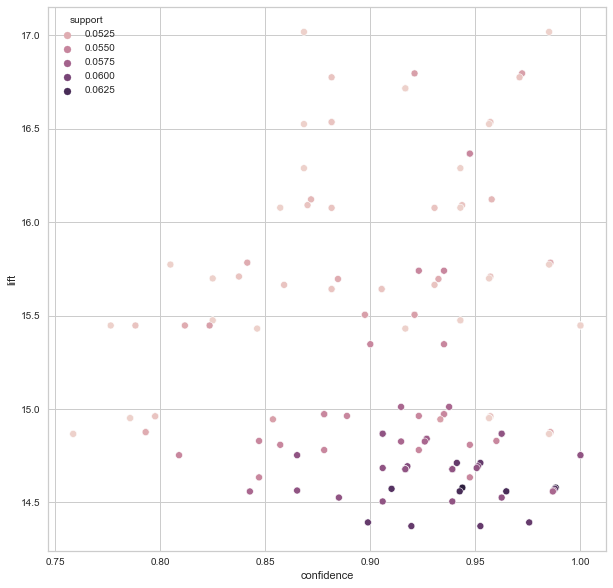

In [16]:
fig = plt.figure(figsize=(10,10)) 
sns.scatterplot(data=rulesLift, x="confidence", y="lift", hue="support")

# 3 - Clustering 

Clustering Functions

In [17]:
def number_clusters(df,cluster_model):
    metrics=['silhouette','distortion','calinski_harabasz']
    model=cluster_model
    for score in metrics:
        plt.figure()
        plt.ylabel(score)
        plt.xlabel('Number of clusters')
        Visualizer=KElbowVisualizer(model,metric=score).fit(df)
        plt.show

In [18]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [19]:
def gmm_config(data,limit_nrcomponents):
    bic_values =[]
    aic_values =[]
    types_covariance=['full','diag','spherical']
    for i in types_covariance:
        n_components = np.arange(1, limit_nrcomponents)
        models = [GaussianMixture(n, covariance_type=i, n_init=10, random_state=1).fit(data)
                  for n in n_components]
        bic_values.append([m.bic(data) for m in models])
        aic_values.append([m.aic(data) for m in models])
    #barplot for BIC
    bic=plt.figure(1)
    X = np.arange(1,limit_nrcomponents)
    plt.bar(X + 0.00, bic_values[0], label='full' ,color = 'b', width = 0.3)
    plt.bar(X + 0.25, bic_values[1], label='diag',color = 'g', width = 0.3)
    plt.bar(X + 0.50, bic_values[2], label='spherical',color = 'r', width = 0.3)
    plt.xlabel('number of components')
    plt.ylabel('BIC')
    plt.legend(loc='best')
   #barplot for AIC
    aic=plt.figure(2)
    X = np.arange(1,limit_nrcomponents)
    plt.bar(X + 0.00, aic_values[0], label='full' ,color = 'b', width = 0.3)
    plt.bar(X + 0.25, aic_values[1], label='diag',color = 'g', width = 0.3)
    plt.bar(X + 0.50, aic_values[2], label='spherical',color = 'r', width = 0.3)
    plt.xlabel('number of components')
    plt.ylabel('AIC')
    plt.legend(loc='best')
    bic.show
    aic.show

In [20]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) #get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [21]:
#on 'type_covariance'-you have to insert with '', for example 'full'
def gmm_components(data,type_covariance,min_components,max_components):
    # Selecting number of components based on AIC and BIC
    n_components = np.arange(min_components,max_components)
    models = [GaussianMixture(n, covariance_type=type_covariance, n_init=10, random_state=1).fit(data)
              for n in n_components]

    bic_values = [m.bic(data) for m in models]
    aic_values = [m.aic(data) for m in models]
    plt.plot(n_components, bic_values, label='BIC')
    plt.plot(n_components, aic_values, label='AIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.xticks(n_components)
    plt.show()

### DataSet for clustering by value

In [22]:
df = pd.read_csv(pathPP, usecols=['ProductName_ID','Point-of-Sale_ID','Value'])

In [23]:
table = pd.pivot_table(df, values='Value', index=['Point-of-Sale_ID'],
                    columns=['ProductName_ID'], aggfunc=np.sum)

In [24]:
table = table.fillna(0)

In [25]:
#Normalize the dataset to run the clustering methods
names = table.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(table)
scaled_df = pd.DataFrame(scaled_df, columns=names)
  
# Normalizing the Data 
normalized_data = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_data = pd.DataFrame(normalized_data,columns=names) 

## DataSet for clustering by product preference

In [26]:
df2 = pd.read_csv(pathPP, usecols=['ProductName_ID','Point-of-Sale_ID','Units'])

In [27]:
table2 = pd.pivot_table(df2, values='Units', index=['Point-of-Sale_ID'],
                    columns=['ProductName_ID'], aggfunc=np.sum)

In [28]:
table2 = table2.fillna(0)

In [29]:
#Normalize the dataset to run the clustering methods
names = table2.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(table2)
scaled_df = pd.DataFrame(scaled_df, columns=names)
  
# Normalizing the Data 
normalized_data2 = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_data2 = pd.DataFrame(normalized_data2,columns=names) 

### Clustering for value

KMeans


K-Elbow plots

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning:

No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning:

No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning:

No '

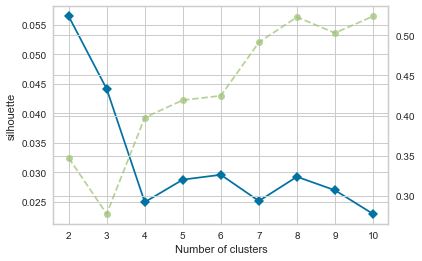

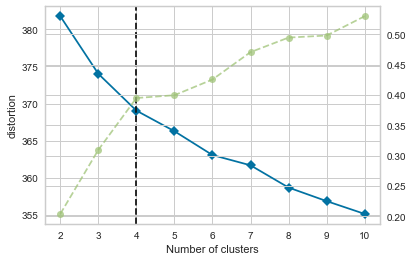

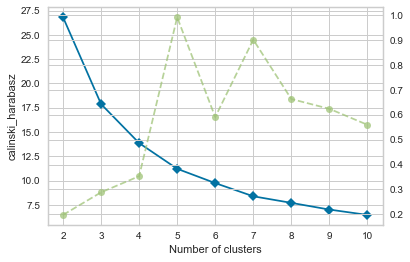

In [30]:
number_clusters(normalized_data ,KMeans( init='k-means++', n_init=15, random_state=1))

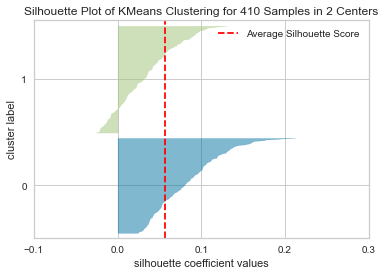

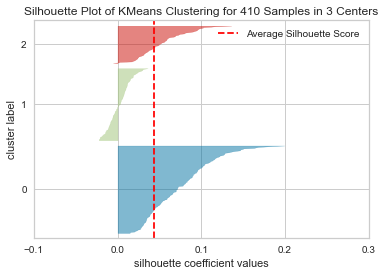

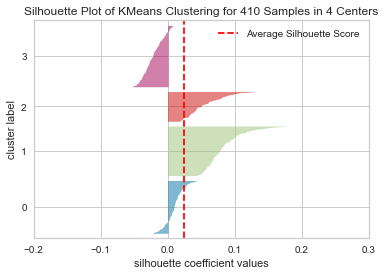

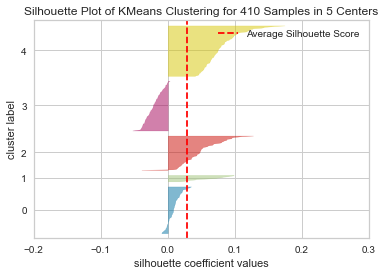

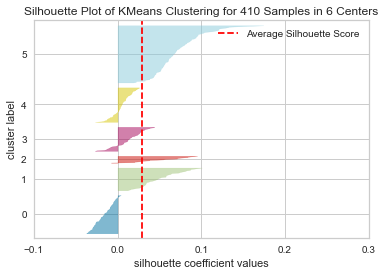

In [31]:
[SilhouetteVisualizer(KMeans(n_clusters=i,init='k-means++', n_init=15, random_state=1), colors='yellowbrick').fit(normalized_data).show() for i in range(2,7)]

In [32]:

#According to the KElbowVisualizer and the SilhouetteVisualizer we were able to determine that the optimal number of clusters is 4.
#confirmar nº de k
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(normalized_data)
df_concat = pd.concat((normalized_data, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

1         2         3         4         5         6         7     \
labels                                                                         
0      -0.001918 -0.009828 -0.008974 -0.008030 -0.011677 -0.012304 -0.006460   
1       0.001668 -0.003368  0.000327  0.003502  0.003018  0.003209 -0.000283   
2      -0.000735  0.013749  0.009128  0.003196  0.008045  0.007827  0.006561   

            8         9         10    ...      2841      2842      2843  \
labels                                ...                                 
0      -0.008195 -0.007420 -0.002316  ... -0.010745  0.001159  0.000931   
1       0.000121 -0.002561 -0.000269  ...  0.005343 -0.001001 -0.001001   
2       0.008020  0.009888  0.001351  ...  0.003177 -0.000760 -0.000760   

            2844      2845      2846      2847      2848      2849      2850  
labels                                                                        
0      -0.004086 -0.018165 -0.018747 -0.013227 -0.007921 -0.007607 -0.007202  
1       0.000254  0.005739  0.005008  0.010931  0.003044  0.004065  0.002937  
2       0.003125  0.012357  0.014104 -0.003611  0.003408  0.003387  0.004188  

[3 rows x 2820 columns]

In [33]:
#Making a copy of the dataset and appending a column with the cluster assigned to the observation.
km_df = normalized_data.copy()
km_df["km_labels"] = km_labels
km_df

ProductName_ID         1         2         3         4         5         6  \
0              -0.001189 -0.008031 -0.009417 -0.006338  0.016117 -0.006199   
1              -0.002066 -0.013952 -0.015590 -0.012567 -0.017511 -0.011335   
2              -0.001288 -0.006399 -0.009709 -0.011435 -0.009205 -0.015164   
3              -0.001013  0.001517 -0.000816  0.015581  0.005797  0.039990   
4              -0.001552 -0.010482 -0.010664 -0.016561 -0.017550 -0.017837   
..                   ...       ...       ...       ...       ...       ...   
405            -0.001701 -0.011488 -0.013470 -0.018149 -0.019232 -0.018129   
406            -0.001131 -0.007636 -0.008953 -0.010664 -0.012784 -0.010710   
407            -0.001415 -0.009554 -0.011202 -0.015094 -0.015995 -0.018432   
408            -0.001243 -0.008392 -0.009840 -0.013258 -0.014050 -0.016190   
409            -0.000943 -0.004728 -0.007123 -0.006790 -0.009367 -0.009779   

ProductName_ID         7         8         9        10  ...      2842  \
0              -0.006441 -0.007045 -0.006437 -0.001386  ... -0.000818   
1              -0.011189 -0.012239 -0.011183 -0.002408  ... -0.001422   
2              -0.006978 -0.007633 -0.003961 -0.001502  ... -0.000887   
3               0.002124  0.000658 -0.003280 -0.001180  ... -0.000697   
4              -0.008407  0.000158 -0.006618 -0.001809  ... -0.001068   
..                   ...       ...       ...       ...  ...       ...   
405            -0.009213 -0.010077 -0.009208 -0.001982  ... -0.001171   
406            -0.006124 -0.006698 -0.006120 -0.001318  ... -0.000778   
407            -0.007662 -0.008381 -0.007658 -0.001649  ... -0.000974   
408            -0.006730 -0.007362 -0.006726 -0.001448  ... -0.000855   
409            -0.005109 -0.005589 -0.005107 -0.001099  ... -0.000649   

ProductName_ID      2843      2844      2845      2846      2847      2848  \
0              -0.000818 -0.005321  0.001507  0.011357 -0.011922 -0.002829   
1              -0.001422 -0.009243 -0.029515 -0.030589 -0.001053  0.015280   
2              -0.000887 -0.005765  0.001170 -0.009051  0.009918  0.056449   
3              -0.000697 -0.001385  0.018220  0.015061  0.025088  0.014070   
4              -0.001068 -0.006945 -0.006407 -0.013802  0.001847 -0.001590   
..                   ...       ...       ...       ...       ...       ...   
405            -0.001171 -0.007611 -0.018983 -0.028153  0.010840 -0.015174   
406            -0.000778 -0.005059  0.019501 -0.004840  0.040551 -0.010086   
407            -0.000974 -0.006330 -0.011049 -0.014864  0.036500 -0.012620   
408            -0.000855 -0.005560 -0.000463 -0.010961 -0.004043 -0.011085   
409            -0.000649 -0.004221  0.037603  0.019707  0.009119 -0.008415   

ProductName_ID      2849      2850  km_labels  
0               0.006011  0.001728          1  
1               0.002109 -0.019725          0  
2              -0.014353  0.018537          1  
3              -0.000266  0.006642          1  
4               0.009854 -0.007777          1  
..                   ...       ...        ...  
405            -0.017473  0.030263          0  
406            -0.012105 -0.000345          1  
407            -0.015760 -0.014310          0  
408            -0.013843 -0.012569          0  
409            -0.009657 -0.009543          2  

[410 rows x 2821 columns]

GMM

Choosing the type of covariance

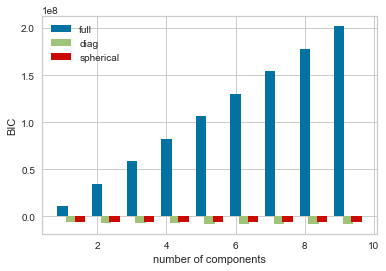

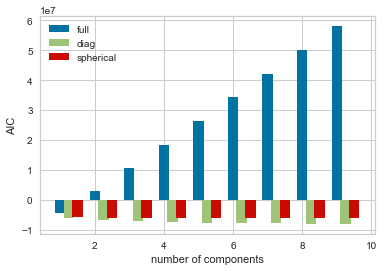

In [34]:
gmm_config(normalized_data,10)

For the most part, the number of components the model with the lowest AIC and BIC is 'diag' 


Applying the clustering

In [35]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=3, covariance_type='diag', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(normalized_data)
# Concatenating the labels to df
df_concat = pd.concat([normalized_data, pd.Series(gmm_labels, index=normalized_data.index, name="gmm_labels")], axis=1)
df_concat.head()

1         2         3         4         5         6         7  \
0 -0.001189 -0.008031 -0.009417 -0.006338  0.016117 -0.006199 -0.006441   
1 -0.002066 -0.013952 -0.015590 -0.012567 -0.017511 -0.011335 -0.011189   
2 -0.001288 -0.006399 -0.009709 -0.011435 -0.009205 -0.015164 -0.006978   
3 -0.001013  0.001517 -0.000816  0.015581  0.005797  0.039990  0.002124   
4 -0.001552 -0.010482 -0.010664 -0.016561 -0.017550 -0.017837 -0.008407   

          8         9        10  ...      2842      2843      2844      2845  \
0 -0.007045 -0.006437 -0.001386  ... -0.000818 -0.000818 -0.005321  0.001507   
1 -0.012239 -0.011183 -0.002408  ... -0.001422 -0.001422 -0.009243 -0.029515   
2 -0.007633 -0.003961 -0.001502  ... -0.000887 -0.000887 -0.005765  0.001170   
3  0.000658 -0.003280 -0.001180  ... -0.000697 -0.000697 -0.001385  0.018220   
4  0.000158 -0.006618 -0.001809  ... -0.001068 -0.001068 -0.006945 -0.006407   

       2846      2847      2848      2849      2850  gmm_labels  
0  0.011357 -0.011922 -0.002829  0.006011  0.001728           1  
1 -0.030589 -0.001053  0.015280  0.002109 -0.019725           1  
2 -0.009051  0.009918  0.056449 -0.014353  0.018537           1  
3  0.015061  0.025088  0.014070 -0.000266  0.006642           0  
4 -0.013802  0.001847 -0.001590  0.009854 -0.007777           1  

[5 rows x 2821 columns]

In [36]:
gmm_ = normalized_data.copy()
gmm_["gmm_labels"] = gmm_labels
gmm_

ProductName_ID         1         2         3         4         5         6  \
0              -0.001189 -0.008031 -0.009417 -0.006338  0.016117 -0.006199   
1              -0.002066 -0.013952 -0.015590 -0.012567 -0.017511 -0.011335   
2              -0.001288 -0.006399 -0.009709 -0.011435 -0.009205 -0.015164   
3              -0.001013  0.001517 -0.000816  0.015581  0.005797  0.039990   
4              -0.001552 -0.010482 -0.010664 -0.016561 -0.017550 -0.017837   
..                   ...       ...       ...       ...       ...       ...   
405            -0.001701 -0.011488 -0.013470 -0.018149 -0.019232 -0.018129   
406            -0.001131 -0.007636 -0.008953 -0.010664 -0.012784 -0.010710   
407            -0.001415 -0.009554 -0.011202 -0.015094 -0.015995 -0.018432   
408            -0.001243 -0.008392 -0.009840 -0.013258 -0.014050 -0.016190   
409            -0.000943 -0.004728 -0.007123 -0.006790 -0.009367 -0.009779   

ProductName_ID         7         8         9        10  ...      2842  \
0              -0.006441 -0.007045 -0.006437 -0.001386  ... -0.000818   
1              -0.011189 -0.012239 -0.011183 -0.002408  ... -0.001422   
2              -0.006978 -0.007633 -0.003961 -0.001502  ... -0.000887   
3               0.002124  0.000658 -0.003280 -0.001180  ... -0.000697   
4              -0.008407  0.000158 -0.006618 -0.001809  ... -0.001068   
..                   ...       ...       ...       ...  ...       ...   
405            -0.009213 -0.010077 -0.009208 -0.001982  ... -0.001171   
406            -0.006124 -0.006698 -0.006120 -0.001318  ... -0.000778   
407            -0.007662 -0.008381 -0.007658 -0.001649  ... -0.000974   
408            -0.006730 -0.007362 -0.006726 -0.001448  ... -0.000855   
409            -0.005109 -0.005589 -0.005107 -0.001099  ... -0.000649   

ProductName_ID      2843      2844      2845      2846      2847      2848  \
0              -0.000818 -0.005321  0.001507  0.011357 -0.011922 -0.002829   
1              -0.001422 -0.009243 -0.029515 -0.030589 -0.001053  0.015280   
2              -0.000887 -0.005765  0.001170 -0.009051  0.009918  0.056449   
3              -0.000697 -0.001385  0.018220  0.015061  0.025088  0.014070   
4              -0.001068 -0.006945 -0.006407 -0.013802  0.001847 -0.001590   
..                   ...       ...       ...       ...       ...       ...   
405            -0.001171 -0.007611 -0.018983 -0.028153  0.010840 -0.015174   
406            -0.000778 -0.005059  0.019501 -0.004840  0.040551 -0.010086   
407            -0.000974 -0.006330 -0.011049 -0.014864  0.036500 -0.012620   
408            -0.000855 -0.005560 -0.000463 -0.010961 -0.004043 -0.011085   
409            -0.000649 -0.004221  0.037603  0.019707  0.009119 -0.008415   

ProductName_ID      2849      2850  gmm_labels  
0               0.006011  0.001728           1  
1               0.002109 -0.019725           1  
2              -0.014353  0.018537           1  
3              -0.000266  0.006642           0  
4               0.009854 -0.007777           1  
..                   ...       ...         ...  
405            -0.017473  0.030263           1  
406            -0.012105 -0.000345           1  
407            -0.015760 -0.014310           1  
408            -0.013843 -0.012569           1  
409            -0.009657 -0.009543           0  

[410 rows x 2821 columns]

### Hierarquical Clustering

In [37]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(normalized_data)
hc_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1, 2, 2, 1, 2, 0, 2, 2,
       2, 2, 1, 1, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 2, 1, 1, 0, 2, 2, 2, 2, 2, 2, 0,
       1, 2, 0, 2, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 3, 0, 1, 3, 0, 1, 1, 0, 0, 0, 2, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 3, 0, 0, 3, 0, 0, 3, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 0, 3, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3,
       3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0, 2, 3, 2, 2, 2,
       3, 2, 2, 0, 2, 2, 2, 0, 0, 3, 3, 0, 3, 2, 0,

In [38]:
# Computing SST
X = normalized_data.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True, ...,  True,  True,  True])

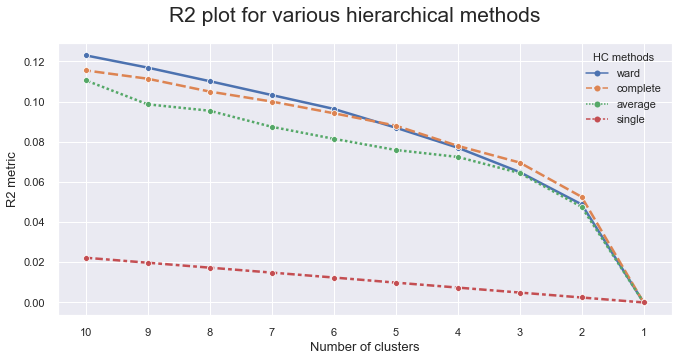

In [39]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=normalized_data, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [40]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'complete'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(normalized_data)

array([321, 255, 359, 265, 381, 331, 232, 305, 343, 365, 297, 223, 282,
       211, 281, 295, 249, 325, 205, 347, 216, 351, 253, 292, 307, 234,
       391, 334, 235, 274, 296, 362, 333, 243, 342, 385, 279, 382, 207,
       222, 225, 247, 224, 323, 393, 315, 262, 375, 352, 392, 320, 271,
       208, 244, 306, 260, 316, 355, 227, 212, 401, 286, 285, 252, 298,
       308, 377, 280, 258, 210, 221, 379, 220, 363, 269, 399, 239, 371,
       395, 303, 396, 376, 217, 299, 344, 312, 259, 219, 311, 291, 289,
       294, 367, 145, 231, 236, 386, 264, 380, 387, 261, 407, 272, 266,
       390, 293, 115, 327, 403, 337, 383, 268, 187, 313, 349, 370, 276,
       277, 230, 335, 284, 328, 209, 356, 273, 117, 275, 146, 233, 240,
       147, 283, 301, 314, 119, 270, 242, 373, 341, 137, 317, 348, 346,
       378, 338, 228, 105, 357, 175, 267, 237, 197, 246, 290, 350, 309,
       192, 405, 121, 250, 389, 332, 241, 153, 324, 329, 409, 213, 278,
       136, 254, 226, 368, 406, 256, 204, 340,  72, 195, 110, 31

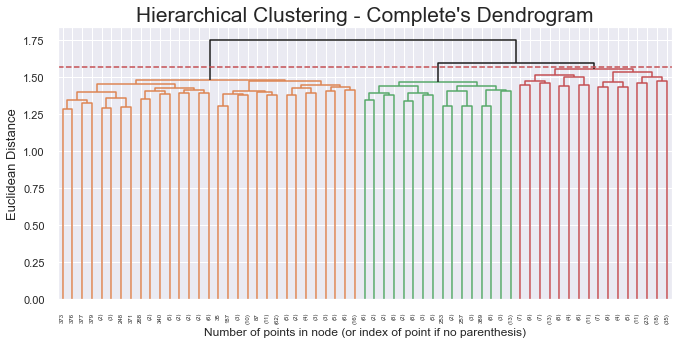

In [41]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 1.57
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [42]:
# 3 cluster solution
linkage = 'average'
distance = 'euclidean'
hc3lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=3)
hc3_labels = hc3lust.fit_predict(normalized_data)

In [43]:
# Characterizing the 3 clusters
HC= pd.concat((normalized_data, pd.Series(hc3_labels, name='labels')), axis=1)
HC.groupby('labels').mean()

1         2         3         4         5         6         7     \
labels                                                                         
0      -0.001822 -0.008945 -0.007657 -0.006869 -0.009589 -0.011026 -0.004665   
1      -0.000304 -0.002150 -0.002544  0.001158  0.002294  0.002903 -0.004210   
2       0.002660  0.009128  0.010209  0.006880  0.008106  0.009614  0.006970   

            8         9         10    ...      2841      2842      2843  \
labels                                ...                                 
0      -0.006836 -0.006547 -0.001201  ... -0.009942  0.000835  0.000643   
1       0.001115 -0.002491 -0.001760  ...  0.006150 -0.001039 -0.001039   
2       0.005240  0.006852  0.000684  ...  0.006631 -0.000811 -0.000811   

            2844      2845      2846      2847      2848      2849      2850  
labels                                                                        
0      -0.004177 -0.013249 -0.014428 -0.010004 -0.008259 -0.004454 -0.004612  
1       0.001336  0.002151  0.006149  0.009550  0.000732  0.001475  0.000135  
2       0.003149  0.011783  0.009776  0.002138  0.009960  0.003128  0.004399  

[3 rows x 2820 columns]

#### Metrica para comparar clusters

In [44]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable
def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst

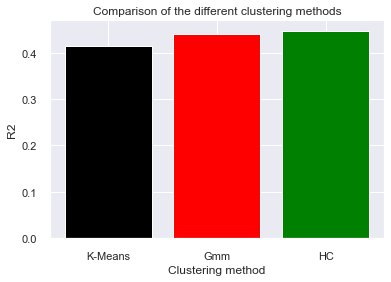

The r2 of the k-means method is 0.42
The r2 of the GMM method is 0.44
The r2 of the HC method is 0.45


In [45]:
r2_list = [r2(km_df, 'km_labels'), r2(gmm_, 'gmm_labels'), r2(HC, 'labels')]
r2_tograph = np.asarray(r2_list)
# Create a List of Labels for x-axis
names = ["K-Means", "Gmm","HC"]
# Make the Chart
plt.bar(names, r2_tograph, color=['black', 'red', 'green'])
plt.title('Comparison of the different clustering methods')
plt.xlabel('Clustering method')
plt.ylabel('R2')
# Show the Chart
plt.show()


print('The r2 of the k-means method is', r2(km_df, 'km_labels').round(2))
print('The r2 of the GMM method is', r2(gmm_, 'gmm_labels').round(2))
print('The r2 of the HC method is', r2(HC, 'labels').round(2))

Due the fact that the all cluster methods have the same number of clusters we can choose the best method by comparing the r^2 of each method
After analyse the previous barplot we came to the conclusion that the HC is the best method

In [46]:
#Clusters to analyse
table = table.reset_index()
HC_final = pd.concat((table , pd.Series(hc3_labels, name='labels')), axis=1)
HC_final = HC_final.set_index('Point-of-Sale_ID')
HC_final

1        2        3         4        5         6       7  \
Point-of-Sale_ID                                                               
1                 0.0      0.0      0.0   20760.0  29690.0   45700.0     0.0   
2                 0.0      0.0   1740.0   17832.0   3380.0   44100.0     0.0   
3                 0.0   3242.0   1792.0    6976.0   4971.0    7363.0     0.0   
4                 0.0  14975.0  33272.0  101293.0  20340.0  307052.0  1650.0   
5                 0.0      0.0   4905.0       0.0      0.0    8990.0     0.0   
...               ...      ...      ...       ...      ...       ...     ...   
406               0.0      0.0      0.0       0.0      0.0   13866.0     0.0   
407               0.0      0.0      0.0    4814.0      0.0   20796.0     0.0   
408               0.0      0.0      0.0       0.0      0.0       0.0     0.0   
409               0.0      0.0      0.0       0.0      0.0       0.0     0.0   
410               0.0   3160.0   1720.0   13500.0   1645.0   15570.0     0.0   

                       8        9   10  ...  2842  2843   2844        2845  \
Point-of-Sale_ID                        ...                                  
1                    0.0      0.0  0.0  ...   0.0   0.0    0.0   914584.00   
2                    0.0      0.0  0.0  ...   0.0   0.0    0.0   261659.00   
3                    0.0  39878.0  0.0  ...   0.0   0.0    0.0   899528.00   
4                 3000.0  37080.0  0.0  ...   0.0   0.0  638.0  1616587.00   
5                 2750.0  19600.0  0.0  ...   0.0   0.0    0.0   688120.00   
...                  ...      ...  ...  ...   ...   ...    ...         ...   
406                  0.0      0.0  0.0  ...   0.0   0.0    0.0   392930.00   
407                  0.0      0.0  0.0  ...   0.0   0.0    0.0  1585422.75   
408                  0.0      0.0  0.0  ...   0.0   0.0    0.0   533549.00   
409                  0.0      0.0  0.0  ...   0.0   0.0    0.0   845769.00   
410                  0.0      0.0  0.0  ...   0.0   0.0    0.0  2534670.50   

                          2846          2847      2848     2849      2850  \
Point-of-Sale_ID                                                            
1                 2.506836e+06  8.589670e+06   47352.0  61767.0   44804.0   
2                 5.054490e+05  1.562870e+07  118112.0  46383.0    2197.0   
3                 1.144853e+06  2.169964e+07  381725.0      0.0   94903.0   
4                 2.944077e+06  3.432967e+07  165136.0  41488.0   64577.0   
5                 9.914450e+05  1.688569e+07   57156.0  66702.0   19773.0   
...                        ...           ...       ...      ...       ...   
406               3.621490e+05  2.071944e+07       0.0   3310.0  108085.0   
407               1.370353e+06  4.253559e+07       0.0   1655.0   37997.0   
408               8.587820e+05  3.509062e+07       0.0      0.0       0.0   
409               9.972680e+05  1.359883e+07       0.0      0.0       0.0   
410               3.438624e+06  2.315618e+07       0.0   3448.0       0.0   

                  labels  
Point-of-Sale_ID          
1                      1  
2                      1  
3                      1  
4                      1  
5                      1  
...                  ...  
406                    0  
407                    0  
408                    0  
409                    0  
410                    0  

[410 rows x 2821 columns]

In [47]:
#Saving the clusters to analyse later
cluster10 = HC_final.loc[HC_final['labels'] == 0]
cluster11 = HC_final.loc[HC_final['labels'] == 1]
cluster12 = HC_final.loc[HC_final['labels'] == 2]


#check if we didn't lost any POS
len(HC_final) == len(cluster11) + len(cluster12)  +len(cluster10)

True

In [48]:
#save the clusters in a csv to use later 

cluster10.to_csv('cluster10.csv', index=False)
cluster11.to_csv('cluster11.csv', index=False)
cluster12.to_csv('cluster12.csv', index=False)

### Clustering for product

KMeans

K-Elbow plots

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning:

No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning:

No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning:

No '

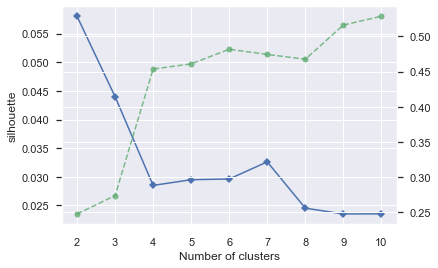

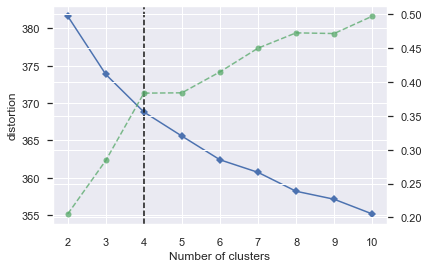

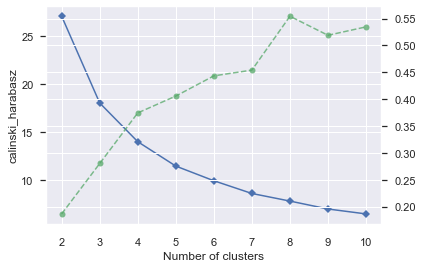

In [49]:
number_clusters(normalized_data2 ,KMeans( init='k-means++', n_init=15, random_state=1))

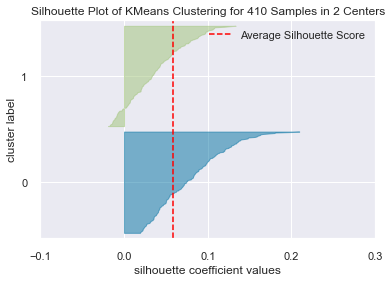

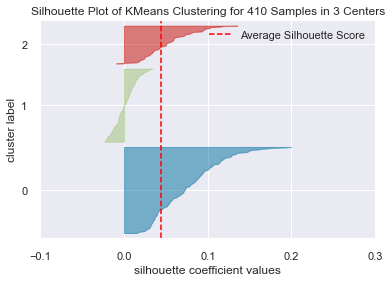

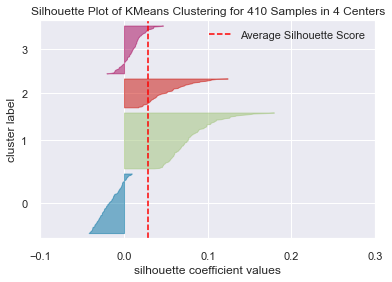

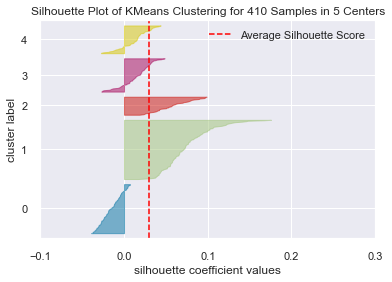

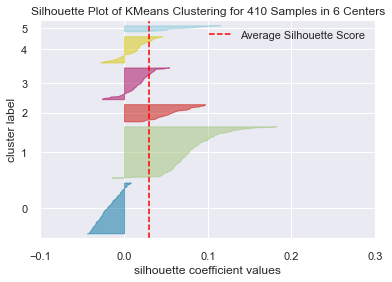

In [50]:
[SilhouetteVisualizer(KMeans(n_clusters=i,init='k-means++', n_init=15, random_state=1), colors='yellowbrick').fit(normalized_data2).show() for i in range(2,7)]

In [51]:
#According to the KElbowVisualizer and the SilhouetteVisualizer we were able to determine that the optimal number of clusters is 4.
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(normalized_data2)
df_concat = pd.concat((normalized_data2, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

1         2         3         4         5         6         7     \
labels                                                                         
0      -0.000630 -0.007160 -0.004561 -0.002292 -0.004424 -0.003069 -0.001166   
1      -0.002041 -0.010446 -0.010362 -0.010415 -0.013821 -0.016112 -0.009658   
2      -0.000666  0.016648  0.011956  0.004003  0.008129  0.007757  0.008762   
3       0.001956 -0.000603  0.002165  0.006189  0.006725  0.007109  0.000783   

            8         9         10    ...      2841      2842      2843  \
labels                                ...                                 
0      -0.002854 -0.004016 -0.001813  ... -0.002200 -0.001108 -0.001108   
1      -0.010053 -0.009371 -0.002385  ... -0.013415  0.002405  0.002053   
2       0.009682  0.012347  0.001980  ...  0.002019 -0.000745 -0.000745   
3       0.001279 -0.000603  0.000294  ...  0.008726 -0.000944 -0.000944   

            2844      2845      2846      2847      2848      2849      2850  
labels                                                                        
0      -0.000578 -0.006378 -0.005666 -0.000096 -0.001975 -0.001076 -0.002418  
1      -0.005272 -0.021560 -0.023098 -0.017577 -0.010700 -0.009910 -0.007468  
2       0.003419  0.010492  0.012153 -0.006195  0.002569  0.000887  0.002582  
3       0.000325  0.012289  0.011456  0.014001  0.006596  0.007239  0.004855  

[4 rows x 2820 columns]

In [52]:
#Making a copy of the dataset and appending a column with the cluster assigned to the observation.
km_df2 = normalized_data.copy()
km_df2["km_labels"] = km_labels
km_df2

ProductName_ID         1         2         3         4         5         6  \
0              -0.001189 -0.008031 -0.009417 -0.006338  0.016117 -0.006199   
1              -0.002066 -0.013952 -0.015590 -0.012567 -0.017511 -0.011335   
2              -0.001288 -0.006399 -0.009709 -0.011435 -0.009205 -0.015164   
3              -0.001013  0.001517 -0.000816  0.015581  0.005797  0.039990   
4              -0.001552 -0.010482 -0.010664 -0.016561 -0.017550 -0.017837   
..                   ...       ...       ...       ...       ...       ...   
405            -0.001701 -0.011488 -0.013470 -0.018149 -0.019232 -0.018129   
406            -0.001131 -0.007636 -0.008953 -0.010664 -0.012784 -0.010710   
407            -0.001415 -0.009554 -0.011202 -0.015094 -0.015995 -0.018432   
408            -0.001243 -0.008392 -0.009840 -0.013258 -0.014050 -0.016190   
409            -0.000943 -0.004728 -0.007123 -0.006790 -0.009367 -0.009779   

ProductName_ID         7         8         9        10  ...      2842  \
0              -0.006441 -0.007045 -0.006437 -0.001386  ... -0.000818   
1              -0.011189 -0.012239 -0.011183 -0.002408  ... -0.001422   
2              -0.006978 -0.007633 -0.003961 -0.001502  ... -0.000887   
3               0.002124  0.000658 -0.003280 -0.001180  ... -0.000697   
4              -0.008407  0.000158 -0.006618 -0.001809  ... -0.001068   
..                   ...       ...       ...       ...  ...       ...   
405            -0.009213 -0.010077 -0.009208 -0.001982  ... -0.001171   
406            -0.006124 -0.006698 -0.006120 -0.001318  ... -0.000778   
407            -0.007662 -0.008381 -0.007658 -0.001649  ... -0.000974   
408            -0.006730 -0.007362 -0.006726 -0.001448  ... -0.000855   
409            -0.005109 -0.005589 -0.005107 -0.001099  ... -0.000649   

ProductName_ID      2843      2844      2845      2846      2847      2848  \
0              -0.000818 -0.005321  0.001507  0.011357 -0.011922 -0.002829   
1              -0.001422 -0.009243 -0.029515 -0.030589 -0.001053  0.015280   
2              -0.000887 -0.005765  0.001170 -0.009051  0.009918  0.056449   
3              -0.000697 -0.001385  0.018220  0.015061  0.025088  0.014070   
4              -0.001068 -0.006945 -0.006407 -0.013802  0.001847 -0.001590   
..                   ...       ...       ...       ...       ...       ...   
405            -0.001171 -0.007611 -0.018983 -0.028153  0.010840 -0.015174   
406            -0.000778 -0.005059  0.019501 -0.004840  0.040551 -0.010086   
407            -0.000974 -0.006330 -0.011049 -0.014864  0.036500 -0.012620   
408            -0.000855 -0.005560 -0.000463 -0.010961 -0.004043 -0.011085   
409            -0.000649 -0.004221  0.037603  0.019707  0.009119 -0.008415   

ProductName_ID      2849      2850  km_labels  
0               0.006011  0.001728          3  
1               0.002109 -0.019725          0  
2              -0.014353  0.018537          0  
3              -0.000266  0.006642          3  
4               0.009854 -0.007777          0  
..                   ...       ...        ...  
405            -0.017473  0.030263          0  
406            -0.012105 -0.000345          3  
407            -0.015760 -0.014310          0  
408            -0.013843 -0.012569          0  
409            -0.009657 -0.009543          3  

[410 rows x 2821 columns]

GMM

Choosing the type of covariance

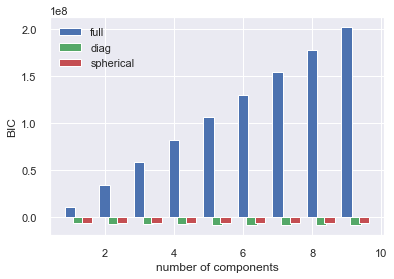

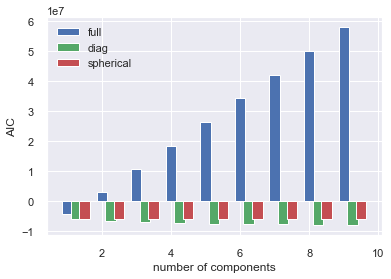

In [53]:
gmm_config(normalized_data2,10)

For the most part, the number of components the model with the lowest AIC and BIC is 'diag' 


Find the number of components

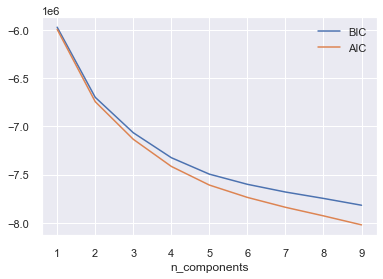

In [54]:
gmm_components(normalized_data2,'diag',1,10)

According to the graph, the teams considers the optimal number of components is 5.

Applying the clustering

In [55]:
# Performing GMM clustering
gmm = GaussianMixture(n_components=5, covariance_type='diag', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(normalized_data)
# Concatenating the labels to df
df_concat = pd.concat([normalized_data, pd.Series(gmm_labels, index=normalized_data.index, name="gmm_labels")], axis=1)
df_concat.head()

1         2         3         4         5         6         7  \
0 -0.001189 -0.008031 -0.009417 -0.006338  0.016117 -0.006199 -0.006441   
1 -0.002066 -0.013952 -0.015590 -0.012567 -0.017511 -0.011335 -0.011189   
2 -0.001288 -0.006399 -0.009709 -0.011435 -0.009205 -0.015164 -0.006978   
3 -0.001013  0.001517 -0.000816  0.015581  0.005797  0.039990  0.002124   
4 -0.001552 -0.010482 -0.010664 -0.016561 -0.017550 -0.017837 -0.008407   

          8         9        10  ...      2842      2843      2844      2845  \
0 -0.007045 -0.006437 -0.001386  ... -0.000818 -0.000818 -0.005321  0.001507   
1 -0.012239 -0.011183 -0.002408  ... -0.001422 -0.001422 -0.009243 -0.029515   
2 -0.007633 -0.003961 -0.001502  ... -0.000887 -0.000887 -0.005765  0.001170   
3  0.000658 -0.003280 -0.001180  ... -0.000697 -0.000697 -0.001385  0.018220   
4  0.000158 -0.006618 -0.001809  ... -0.001068 -0.001068 -0.006945 -0.006407   

       2846      2847      2848      2849      2850  gmm_labels  
0  0.011357 -0.011922 -0.002829  0.006011  0.001728           4  
1 -0.030589 -0.001053  0.015280  0.002109 -0.019725           3  
2 -0.009051  0.009918  0.056449 -0.014353  0.018537           4  
3  0.015061  0.025088  0.014070 -0.000266  0.006642           4  
4 -0.013802  0.001847 -0.001590  0.009854 -0.007777           1  

[5 rows x 2821 columns]

In [56]:
gmm_2 = table2.copy()
gmm_2["gmm_labels"] = df_concat['gmm_labels']
gmm_2

ProductName_ID      1    2     3     4     5      6    7    8    9   10  ...  \
Point-of-Sale_ID                                                         ...   
1                 0.0  0.0   0.0  12.0  17.0   20.0  0.0  0.0  0.0  0.0  ...   
2                 0.0  0.0   1.0  10.0   2.0   19.0  0.0  0.0  0.0  0.0  ...   
3                 0.0  1.0   1.0   4.0   3.0    3.0  0.0  0.0  4.0  0.0  ...   
4                 0.0  5.0  20.0  57.0  13.0  145.0  1.0  1.0  4.0  0.0  ...   
5                 0.0  0.0   3.0   0.0   0.0    4.0  0.0  1.0  2.0  0.0  ...   
...               ...  ...   ...   ...   ...    ...  ...  ...  ...  ...  ...   
406               0.0  0.0   0.0   0.0   0.0    6.0  0.0  0.0  0.0  0.0  ...   
407               0.0  0.0   0.0   2.0   0.0   11.0  0.0  0.0  0.0  0.0  ...   
408               0.0  0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  ...   
409               0.0  0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  0.0  ...   
410               0.0  1.0   1.0   6.0   1.0    7.0  0.0  0.0  0.0  0.0  ...   

ProductName_ID    2842  2843  2844    2845    2846    2847   2848  2849  2850  \
Point-of-Sale_ID                                                                
1                  0.0   0.0   0.0  1039.0  1530.0  1782.0   30.0  37.0  20.0   
2                  0.0   0.0   0.0   297.0   345.0  3274.0   77.0  28.0   1.0   
3                  0.0   0.0   0.0  1021.0   759.0  4553.0  269.0   0.0  43.0   
4                  0.0   0.0   1.0  1835.0  1903.0  7163.0  112.0  25.0  29.0   
5                  0.0   0.0   0.0   781.0   643.0  3533.0   42.0  40.0   9.0   
...                ...   ...   ...     ...     ...     ...    ...   ...   ...   
406                0.0   0.0   0.0   446.0   210.0  4338.0    0.0   2.0  49.0   
407                0.0   0.0   0.0  1800.0   784.0  8886.0    0.0   1.0  17.0   
408                0.0   0.0   0.0   606.0   477.0  7378.0    0.0   0.0   0.0   
409                0.0   0.0   0.0   960.0   566.0  2843.0    0.0   0.0   0.0   
410                0.0   0.0   0.0  2879.0  2044.0  4831.0    0.0   2.0   0.0   

ProductName_ID    gmm_labels  
Point-of-Sale_ID              
1                        3.0  
2                        4.0  
3                        4.0  
4                        1.0  
5                        1.0  
...                      ...  
406                      4.0  
407                      1.0  
408                      1.0  
409                      4.0  
410                      NaN  

[410 rows x 2821 columns]

## HC

In [57]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(normalized_data2)
hc_labels

array([3, 3, 3, 3, 3, 0, 0, 3, 3, 0, 3, 3, 1, 3, 3, 1, 1, 3, 1, 0, 1, 1,
       1, 1, 3, 3, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 3, 3, 1, 3, 3,
       3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 0, 3, 1, 1, 3, 3, 0, 3, 1, 3, 3, 0, 1, 1, 1, 1, 1, 1, 0,
       3, 1, 0, 1, 1, 0, 0, 2, 0, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 3, 3, 2, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 3,
       3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 2, 0, 3, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 2, 0, 3, 3, 3, 0, 3, 0, 0,
       0, 0, 3, 0, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 0, 2, 2, 2, 2, 2, 0,
       0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 3, 2, 0, 0, 3, 0, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 4, 1, 0, 4, 0, 2, 4, 4, 0, 4, 2, 0, 2, 2,
       2, 2, 4, 4, 2, 2, 2, 4, 4, 0, 4, 4, 4, 2, 2, 4, 2, 1, 4, 1, 2, 1,
       4, 1, 1, 2, 2, 1, 1, 0, 0, 2, 4, 0, 4, 2, 0,

In [58]:
# Computing SST
X = normalized_data2.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True, ...,  True,  True,  True])

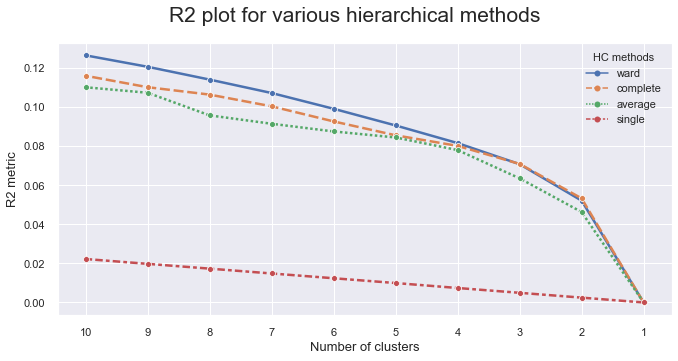

In [59]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack([get_r2_hc(df=normalized_data2, link_method=link, max_nclus=max_nclus) for link in hc_methods]).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [60]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(normalized_data2)

array([317, 254, 379, 269, 217, 326, 207, 293, 231, 361, 335, 244, 299,
       273, 225, 319, 263, 294, 357, 336, 222, 350, 213, 328, 300, 303,
       209, 332, 377, 277, 314, 362, 291, 279, 343, 230, 375, 382, 296,
       223, 381, 289, 329, 380, 337, 331, 239, 378, 355, 392, 391, 276,
       347, 261, 245, 260, 323, 325, 285, 235, 206, 224, 282, 360, 287,
       310, 371, 409, 229, 367, 232, 189, 359, 344, 311, 214, 318, 372,
       215, 267, 397, 376, 272, 387, 286, 330, 275, 255, 407, 281, 298,
       140, 389, 246, 253, 208, 187, 280, 383, 211, 307, 270, 363, 262,
       394, 292, 241, 327, 259, 134, 216, 268, 122, 349, 348, 185, 274,
       139, 320, 365, 295, 393, 195, 364, 315, 248, 237, 236, 117, 106,
       301, 130, 147, 312, 388, 233, 247, 149, 249, 271, 369, 135, 358,
       368, 165, 240, 227, 305, 297, 309, 313, 395, 242, 190, 346, 385,
       384, 114, 398, 212, 339, 251, 304, 264, 338, 191, 204, 218, 173,
       302, 133, 234, 238, 405, 396, 356, 265,  69, 228, 126, 29

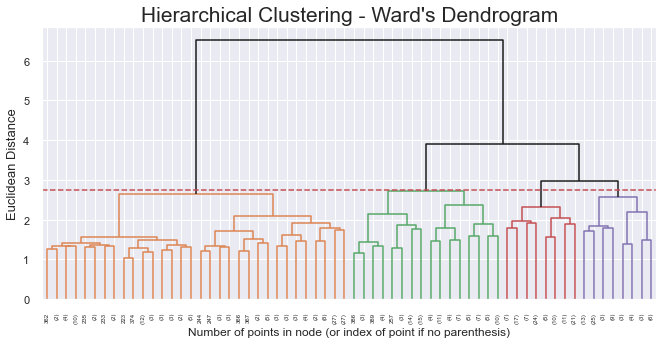

In [61]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 2.75
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [62]:
# 3 cluster solution
linkage = 'average'
distance = 'euclidean'
hc3lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hc3_labels = hc3lust.fit_predict(normalized_data2)

In [63]:
# Characterizing the 3 clusters
HC2= pd.concat((normalized_data, pd.Series(hc3_labels, name='labels')), axis=1)
HC2.groupby('labels').mean()

1         2         3         4         5         6         7     \
labels                                                                         
0      -0.000241 -0.001727  0.000347  0.001330  0.003140  0.004244 -0.004583   
1      -0.001581 -0.006551 -0.001365  0.003360 -0.000498 -0.000613  0.005477   
2       0.002969  0.011388  0.007400  0.004863  0.007620  0.008336  0.007439   
3      -0.001860 -0.010037 -0.008406 -0.007725 -0.011155 -0.012639 -0.006483   

            8         9         10    ...      2841      2842      2843  \
labels                                ...                                 
0       0.000883 -0.000599 -0.001774  ...  0.005793 -0.001047 -0.001047   
1      -0.004177 -0.004755  0.003249  ...  0.004859 -0.001088 -0.001088   
2       0.008011  0.007752  0.000929  ...  0.003973 -0.000787 -0.000787   
3      -0.008210 -0.007799 -0.002249  ... -0.011204  0.001213  0.000983   

            2844      2845      2846      2847      2848      2849      2850  
labels                                                                        
0       0.000480  0.003223  0.007617  0.009148  0.001870  0.002979  0.000501  
1      -0.000464  0.006097  0.002305  0.007595  0.000607  0.000844  0.002299  
2       0.003687  0.011374  0.010441 -0.001084  0.007201  0.003987  0.003167  
3      -0.004552 -0.017026 -0.018447 -0.011867 -0.008726 -0.006602 -0.005395  

[4 rows x 2820 columns]

### Metrica para comparar clusters

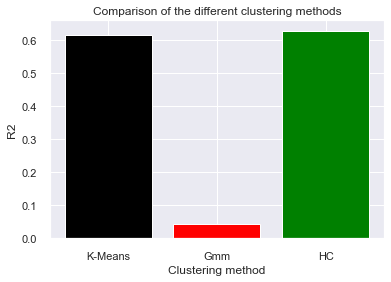

The r2 of the k-means method is 0.61
The r2 of the GMM method is 0.04
The r2 of the HC method is 0.63


In [64]:
r_list = [r2(km_df2, 'km_labels'), r2(gmm_2,'gmm_labels'), r2(HC2, 'labels')]
r_tograph = np.asarray(r_list)
# Create a List of Labels for x-axis
names = ["K-Means", "Gmm","HC"]
# Make the Chart
plt.bar(names, r_tograph, color=['black', 'red', 'green'])
plt.title('Comparison of the different clustering methods')
plt.xlabel('Clustering method')
plt.ylabel('R2')
# Show the Chart
plt.show()

print('The r2 of the k-means method is', r2(km_df2, 'km_labels').round(2))
print('The r2 of the GMM method is', r2(gmm_2, 'gmm_labels').round(2))
print('The r2 of the HC method is', r2(HC2, 'labels').round(2))


Due the fact that the all cluster methods have the same number of variables we can choose the best method by comparing the r^2 of each method After analyse the previous barplot we came to the conclusion that the K-Means is the best method

In [65]:
table2.head()

ProductName_ID    1     2     3     4     5      6     7     8     9     10    \
Point-of-Sale_ID                                                                
1                  0.0   0.0   0.0  12.0  17.0   20.0   0.0   0.0   0.0   0.0   
2                  0.0   0.0   1.0  10.0   2.0   19.0   0.0   0.0   0.0   0.0   
3                  0.0   1.0   1.0   4.0   3.0    3.0   0.0   0.0   4.0   0.0   
4                  0.0   5.0  20.0  57.0  13.0  145.0   1.0   1.0   4.0   0.0   
5                  0.0   0.0   3.0   0.0   0.0    4.0   0.0   1.0   2.0   0.0   

ProductName_ID    ...    2841  2842  2843  2844    2845    2846    2847  \
Point-of-Sale_ID  ...                                                     
1                 ...   785.0   0.0   0.0   0.0  1039.0  1530.0  1782.0   
2                 ...   508.0   0.0   0.0   0.0   297.0   345.0  3274.0   
3                 ...   531.0   0.0   0.0   0.0  1021.0   759.0  4553.0   
4                 ...  1770.0   0.0   0.0   1.0  1835.0  1903.0  7163.0   
5                 ...   734.0   0.0   0.0   0.0   781.0   643.0  3533.0   

ProductName_ID     2848  2849  2850  
Point-of-Sale_ID                     
1                  30.0  37.0  20.0  
2                  77.0  28.0   1.0  
3                 269.0   0.0  43.0  
4                 112.0  25.0  29.0  
5                  42.0  40.0   9.0  

[5 rows x 2820 columns]

In [66]:
#Clusters to analyse
table2 = table2.reset_index()
final_cluster20 = pd.concat((table2 , pd.Series(gmm_labels, name='gmm_labels')), axis=1)
final_cluster20

Point-of-Sale_ID    1    2     3     4     5      6    7    8    9  ...  \
0                   1  0.0  0.0   0.0  12.0  17.0   20.0  0.0  0.0  0.0  ...   
1                   2  0.0  0.0   1.0  10.0   2.0   19.0  0.0  0.0  0.0  ...   
2                   3  0.0  1.0   1.0   4.0   3.0    3.0  0.0  0.0  4.0  ...   
3                   4  0.0  5.0  20.0  57.0  13.0  145.0  1.0  1.0  4.0  ...   
4                   5  0.0  0.0   3.0   0.0   0.0    4.0  0.0  1.0  2.0  ...   
..                ...  ...  ...   ...   ...   ...    ...  ...  ...  ...  ...   
405               406  0.0  0.0   0.0   0.0   0.0    6.0  0.0  0.0  0.0  ...   
406               407  0.0  0.0   0.0   2.0   0.0   11.0  0.0  0.0  0.0  ...   
407               408  0.0  0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  ...   
408               409  0.0  0.0   0.0   0.0   0.0    0.0  0.0  0.0  0.0  ...   
409               410  0.0  1.0   1.0   6.0   1.0    7.0  0.0  0.0  0.0  ...   

     2842  2843  2844    2845    2846    2847   2848  2849  2850  gmm_labels  
0     0.0   0.0   0.0  1039.0  1530.0  1782.0   30.0  37.0  20.0           4  
1     0.0   0.0   0.0   297.0   345.0  3274.0   77.0  28.0   1.0           3  
2     0.0   0.0   0.0  1021.0   759.0  4553.0  269.0   0.0  43.0           4  
3     0.0   0.0   1.0  1835.0  1903.0  7163.0  112.0  25.0  29.0           4  
4     0.0   0.0   0.0   781.0   643.0  3533.0   42.0  40.0   9.0           1  
..    ...   ...   ...     ...     ...     ...    ...   ...   ...         ...  
405   0.0   0.0   0.0   446.0   210.0  4338.0    0.0   2.0  49.0           1  
406   0.0   0.0   0.0  1800.0   784.0  8886.0    0.0   1.0  17.0           4  
407   0.0   0.0   0.0   606.0   477.0  7378.0    0.0   0.0   0.0           1  
408   0.0   0.0   0.0   960.0   566.0  2843.0    0.0   0.0   0.0           1  
409   0.0   0.0   0.0  2879.0  2044.0  4831.0    0.0   2.0   0.0           4  

[410 rows x 2822 columns]

In [67]:
#Saving the clusters to analyse later
cluster20 = final_cluster20.loc[final_cluster20['gmm_labels'] == 0]
cluster21 = final_cluster20.loc[final_cluster20['gmm_labels'] == 1]
cluster22 = final_cluster20.loc[final_cluster20['gmm_labels'] == 2]
cluster23 = final_cluster20.loc[final_cluster20['gmm_labels'] == 3]
cluster24 = final_cluster20.loc[final_cluster20['gmm_labels'] == 4]


In [68]:
#save the clusters to a csv to load lately
cluster20.to_csv('cluster20.csv', index=False)
cluster21.to_csv('cluster21.csv', index=False)
cluster22.to_csv('cluster22.csv', index=False)
cluster23.to_csv('cluster23.csv', index=False)
cluster24.to_csv('cluster24.csv', index=False)


### Clusters Analises

In [69]:
#value
LowValuePOS = pd.read_csv(r'cluster10.csv')
MediumValuePOS = pd.read_csv(r'cluster11.csv')
HighValuesPOS = pd.read_csv(r'cluster12.csv')

#Units
cluster20 = pd.read_csv(r'cluster20.csv')
cluster21 = pd.read_csv(r'cluster21.csv')
cluster22 = pd.read_csv(r'cluster22.csv')
cluster23 = pd.read_csv(r'cluster23.csv')
cluster24 = pd.read_csv(r'cluster24.csv')


## Per value
Distribution of the number of pos in each cluster

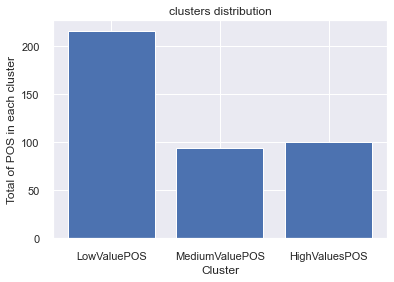

In [70]:
#clusters distribution
list1 = [len(LowValuePOS),len(MediumValuePOS),len(HighValuesPOS)]
list1 = np.asarray(list1)
# Create a List of Labels for x-axis
names = ["LowValuePOS", "MediumValuePOS","HighValuesPOS"]
# Make the Chart
plt.bar(names, list1)
plt.title('clusters distribution')
plt.xlabel('Cluster')
plt.ylabel('Total of POS in each cluster')
# Show the Chart
plt.show()

In [71]:
print('The medium value of sells of the POS in the LowValuePOS are', LowValuePOS.mean().mean(), 'and the total value is', LowValuePOS.sum().sum())

The medium value of sells of the POS in the LowValuePOS are 203712.63681333233 and the total value is 124129443265.2887


In [72]:
print('The medium value of sells of the POS in the LowValuePOS are', MediumValuePOS.mean().mean(), 'and the total value is', MediumValuePOS.sum().sum())

The medium value of sells of the POS in the LowValuePOS are 325757.38339057454 and the total value is 86382388383.2121


In [73]:
print('The medium value of sells of the POS in the LowValuePOS are', HighValuesPOS.mean().mean(), 'and the total value is', HighValuesPOS.sum().sum())

The medium value of sells of the POS in the LowValuePOS are 390814.94092883985 and the total value is 110248894836.02602


## Per product preference

Distribution of the number of pos in each cluster

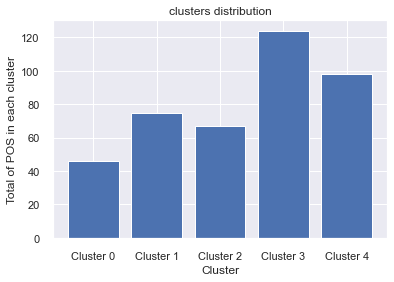

In [74]:

#clusters distribution
list1 = [len(cluster20),len(cluster21),len(cluster22),len(cluster23),len(cluster24)]
list1 = np.asarray(list1)
# Create a List of Labels for x-axis
names = ["Cluster 0", "Cluster 1","Cluster 2", 'Cluster 3', 'Cluster 4']
# Make the Chart
plt.bar(names, list1)
plt.title('clusters distribution')
plt.xlabel('Cluster')
plt.ylabel('Total of POS in each cluster')
# Show the Chart
plt.show()

In [75]:
cluster20.sum().sort_values(ascending= False).head(10)

1147    432951.0
481     367353.0
226     345203.0
1277    323909.0
1846    313436.0
993     297385.0
567     283248.0
2609    272528.0
2802    266192.0
1234    260566.0
dtype: float64

In [76]:
cluster21.sum().sort_values(ascending= False).head(10)

1277    554718.0
2609    536408.0
2802    501866.0
993     466516.0
481     466439.0
847     455082.0
1147    408975.0
1234    404324.0
1422    390361.0
226     382073.0
dtype: float64

In [77]:
cluster22.sum().sort_values(ascending= False).head(10)

1147    756125.0
481     727331.0
993     673211.0
2609    658160.0
1277    656841.0
567     606448.0
1234    595957.0
1422    539240.0
2802    511061.0
847     475987.0
dtype: float64

In [78]:
cluster23.sum().sort_values(ascending= False).head(10)

1277    596426.0
2609    527610.0
481     484141.0
2802    476760.0
993     472170.0
847     445141.0
1147    429888.0
1234    423160.0
1422    402210.0
567     378610.0
dtype: float64

In [79]:
cluster24.sum().sort_values(ascending= False).head(10)

2609    1076061.0
1277    1038750.0
481      938351.0
993      928589.0
226      894702.0
1422     880858.0
1234     844292.0
847      828808.0
1147     773213.0
2802     765844.0
dtype: float64

# -----------------------------------Forecast-------------------------------------------

In [80]:
df=pd.read_csv("values_units.csv")

In [81]:
df_week=df.groupby(by=['Date'], as_index=False)['Units'].sum()
df_week['Date']=df_week['Date'].astype('datetime64[ns]')
df_week = df_week.resample('W', label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')
df_week=df_week.set_index("Date")
df_week

Units
Date                 
2016-01-03   178465.0
2016-01-10  1089816.0
2016-01-17  1077428.0
2016-01-24  1018782.0
2016-01-31   987281.0
...               ...
2019-10-06  1028772.0
2019-10-13  1191241.0
2019-10-20  1089550.0
2019-10-27  1081770.0
2019-11-03   777912.0

[201 rows x 1 columns]

In [82]:
#train test split 
train=df_week[:'01-Jul-2018'].copy()
valid = df_week['01-Jul-2018':].copy()
model=df_week['01-Jul-2018':].copy()

## Decomposition 

<ipython-input-83-263185e3a30b>:1: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



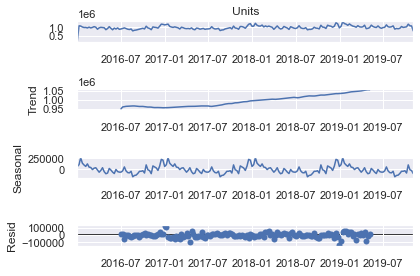

In [83]:
fig = seasonal_decompose(df_week["Units"], model='additive', freq=52).plot()

## Test the stationary

In [84]:
dftest = adfuller(df_week["Units"], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -3.380033
p-value                          0.011659
#Lags Used                      13.000000
Number of Observations Used    187.000000
Critical Value (1%)             -3.465812
Critical Value (5%)             -2.877123
Critical Value (10%)            -2.575077
dtype: float64

## Apply Seasonal Difference

<ipython-input-85-41523dfe32b5>:3: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



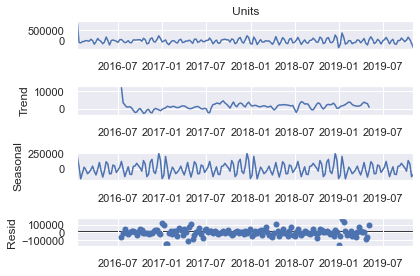

In [85]:
diff_7 = df_week["Units"].diff(2)
diff_7.dropna(inplace=True)
fig = seasonal_decompose(diff_7, model='additive', freq=52).plot()

In [86]:
dftest = adfuller(diff_7, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                  -3.869710
p-value                          0.002269
#Lags Used                      15.000000
Number of Observations Used    183.000000
Critical Value (1%)             -3.466598
Critical Value (5%)             -2.877467
Critical Value (10%)            -2.575260
dtype: float64

The Dickey-Fuller test suggests that the trend has been removed


## ACF and PACF

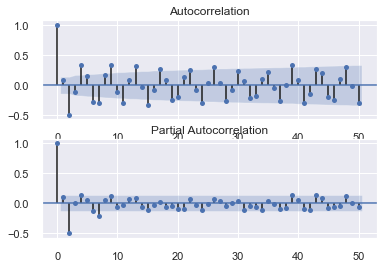

In [87]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(diff_7, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(diff_7, lags=50, ax=ax[1])

The parameters for the model
p: 1 d: 1 q: 1 P: 1 D: 1 Q: 1 m: 4


## Manual Approach

In [88]:
# The team employed the parameters discovered previously,[(1,1,1)(1,1,1,4)], as a starting point to discover  
#better combinations and we ended up with [(3,0,2)(3,2,1,7)].

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



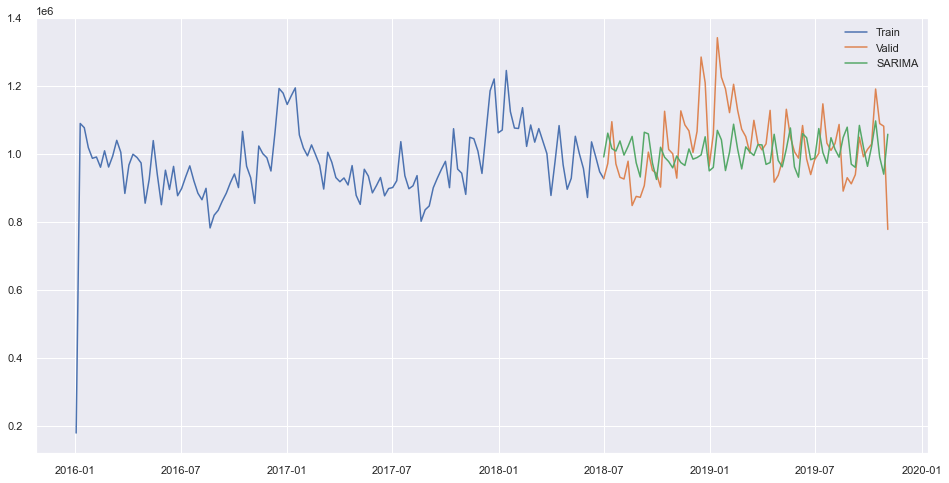

In [89]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
fit1 = SARIMAX(train['Units'], order=(3,0,2),seasonal_order=(3,2,1,7),enforce_stationarity=False,enforce_invertibility=False).fit()
model['SARIMA_Manual'] = fit1.predict(start="01-Jul-2018", end="03-Nov-2019", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Units'], label='Train')
plt.plot(valid['Units'], label='Valid')
plt.plot(model['SARIMA_Manual'], label='SARIMA',color="g")
plt.legend(loc='best')
plt.show()

In [90]:
rmse = sqrt(mean_squared_error(valid['Units'], model.SARIMA_Manual))
mae=mean_absolute_error(valid['Units'], model.SARIMA_Manual)
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape=mean_absolute_percentage_error(y_true=valid['Units'],
                   y_pred=model['SARIMA_Manual'])
print("MAPE_Manual",mape)
print("rmse_Manual:", rmse)
print("MAE_Manual:", mae)

MAPE_Manual 8.357241774323366
rmse_Manual: 109122.49358317794
MAE_Manual: 86471.97509768377


## Base Model 

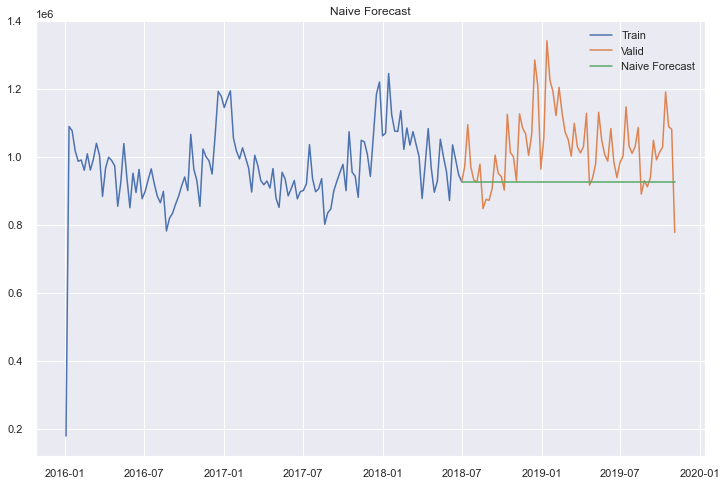

In [91]:
# Using naive approach for the validation set.
dd= np.asarray(train['Units'])

model['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Units'], label='Train')
plt.plot(valid.index,valid['Units'], label='Valid')
plt.plot(model.index,model['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [92]:
rmse = sqrt(mean_squared_error(valid['Units'], model.naive))
mae=mean_absolute_error(valid['Units'], model.naive)
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape=mean_absolute_percentage_error(y_true=valid['Units'],
                   y_pred=model['naive'])
print("MAPE_naive",mape)
print("rmse:_naive", rmse)
print("MAE_naive:", mae)

MAPE_naive 10.269519643381544
rmse:_naive 143429.08058178163
MAE_naive: 111889.66197183098


## Gridsearch

In [93]:
######### This takes a long time to run###########

# Find the parameters with minimal BIC value
import itertools
import statsmodels.api as sm
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
# Define function
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 1 parameter combination
        Returns dataframe of parameter combinations ranked by BIC
    '''

    
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
                print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:1]
    
    return ans_df
    
sarimax_gridsearch(train['Units'], pdq, pdqs, freq='W')

SARIMAX (0, 0, 0) x (0, 0, 0, 7)12 : BIC Calculated =3960.067422662588
SARIMAX (0, 0, 0) x (0, 0, 1, 7)12 : BIC Calculated =3666.504520547854
SARIMAX (0, 0, 0) x (0, 0, 2, 7)12 : BIC Calculated =3449.984699032442


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (0, 1, 0, 7)12 : BIC Calculated =3231.6159605612525
SARIMAX (0, 0, 0) x (0, 1, 1, 7)12 : BIC Calculated =3036.065473663583
SARIMAX (0, 0, 0) x (0, 1, 2, 7)12 : BIC Calculated =2856.6318513653114
SARIMAX (0, 0, 0) x (0, 2, 0, 7)12 : BIC Calculated =3157.535129463447


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (0, 2, 1, 7)12 : BIC Calculated =2901.730464200211


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (0, 2, 2, 7)12 : BIC Calculated =2727.839847213729
SARIMAX (0, 0, 0) x (1, 0, 0, 7)12 : BIC Calculated =3298.692387838661
SARIMAX (0, 0, 0) x (1, 0, 1, 7)12 : BIC Calculated =3230.712465224251


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (1, 0, 2, 7)12 : BIC Calculated =3045.979450555142
SARIMAX (0, 0, 0) x (1, 1, 0, 7)12 : BIC Calculated =3070.2318239303722


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (1, 1, 1, 7)12 : BIC Calculated =3040.5702282772804
SARIMAX (0, 0, 0) x (1, 1, 2, 7)12 : BIC Calculated =2849.0182164592106
SARIMAX (0, 0, 0) x (1, 2, 0, 7)12 : BIC Calculated =2969.8050460813715


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (1, 2, 1, 7)12 : BIC Calculated =2895.4941348717007


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (1, 2, 2, 7)12 : BIC Calculated =2707.4931029646514
SARIMAX (0, 0, 0) x (2, 0, 0, 7)12 : BIC Calculated =3074.6865886720416
SARIMAX (0, 0, 0) x (2, 0, 1, 7)12 : BIC Calculated =3073.6106533112597


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (2, 0, 2, 7)12 : BIC Calculated =3048.0074371896526
SARIMAX (0, 0, 0) x (2, 1, 0, 7)12 : BIC Calculated =2883.5776021240117
SARIMAX (0, 0, 0) x (2, 1, 1, 7)12 : BIC Calculated =2883.3476708806215


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (2, 1, 2, 7)12 : BIC Calculated =2852.705234668733
SARIMAX (0, 0, 0) x (2, 2, 0, 7)12 : BIC Calculated =2758.200653572594


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (2, 2, 1, 7)12 : BIC Calculated =2736.8273672281343


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 0) x (2, 2, 2, 7)12 : BIC Calculated =2701.218490387082
SARIMAX (0, 0, 1) x (0, 0, 0, 7)12 : BIC Calculated =3842.412180864564
SARIMAX (0, 0, 1) x (0, 0, 1, 7)12 : BIC Calculated =3618.2720448174805


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (0, 0, 2, 7)12 : BIC Calculated =3410.331587776092
SARIMAX (0, 0, 1) x (0, 1, 0, 7)12 : BIC Calculated =3175.5121933152823
SARIMAX (0, 0, 1) x (0, 1, 1, 7)12 : BIC Calculated =2979.449322169779


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (0, 1, 2, 7)12 : BIC Calculated =2799.603210449069
SARIMAX (0, 0, 1) x (0, 2, 0, 7)12 : BIC Calculated =3108.9659733117173
SARIMAX (0, 0, 1) x (0, 2, 1, 7)12 : BIC Calculated =2863.4498401456513


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (0, 2, 2, 7)12 : BIC Calculated =2682.086613416689
SARIMAX (0, 0, 1) x (1, 0, 0, 7)12 : BIC Calculated =3664.192688217571
SARIMAX (0, 0, 1) x (1, 0, 1, 7)12 : BIC Calculated =3609.602602706875


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (1, 0, 2, 7)12 : BIC Calculated =3407.9526030672764
SARIMAX (0, 0, 1) x (1, 1, 0, 7)12 : BIC Calculated =3041.3348457739785
SARIMAX (0, 0, 1) x (1, 1, 1, 7)12 : BIC Calculated =2984.159463296929


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (1, 1, 2, 7)12 : BIC Calculated =2796.2256492608913
SARIMAX (0, 0, 1) x (1, 2, 0, 7)12 : BIC Calculated =2950.8819518518026


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (1, 2, 1, 7)12 : BIC Calculated =2865.5341376830165


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (1, 2, 2, 7)12 : BIC Calculated =2682.3859761372782
SARIMAX (0, 0, 1) x (2, 0, 0, 7)12 : BIC Calculated =3462.2483794649233
SARIMAX (0, 0, 1) x (2, 0, 1, 7)12 : BIC Calculated =3466.91088769048


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (2, 0, 2, 7)12 : BIC Calculated =3412.697270358978
SARIMAX (0, 0, 1) x (2, 1, 0, 7)12 : BIC Calculated =2848.311008572658
SARIMAX (0, 0, 1) x (2, 1, 1, 7)12 : BIC Calculated =2849.667595933272


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (2, 1, 2, 7)12 : BIC Calculated =2798.318376061003
SARIMAX (0, 0, 1) x (2, 2, 0, 7)12 : BIC Calculated =2742.999811039325


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (2, 2, 1, 7)12 : BIC Calculated =2736.407673445977


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 1) x (2, 2, 2, 7)12 : BIC Calculated =2683.2308750953794
SARIMAX (0, 0, 2) x (0, 0, 0, 7)12 : BIC Calculated =3794.653293684627
SARIMAX (0, 0, 2) x (0, 0, 1, 7)12 : BIC Calculated =3587.1527802828746


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (0, 0, 2, 7)12 : BIC Calculated =3380.745790915551
SARIMAX (0, 0, 2) x (0, 1, 0, 7)12 : BIC Calculated =3148.515204681442
SARIMAX (0, 0, 2) x (0, 1, 1, 7)12 : BIC Calculated =2946.475033175184


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (0, 1, 2, 7)12 : BIC Calculated =2764.222701636031
SARIMAX (0, 0, 2) x (0, 2, 0, 7)12 : BIC Calculated =3084.419881511106


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (0, 2, 1, 7)12 : BIC Calculated =2835.820539340857


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (0, 2, 2, 7)12 : BIC Calculated =2650.7252910479183
SARIMAX (0, 0, 2) x (1, 0, 0, 7)12 : BIC Calculated =3668.8594680972456
SARIMAX (0, 0, 2) x (1, 0, 1, 7)12 : BIC Calculated =3584.718917636221


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (1, 0, 2, 7)12 : BIC Calculated =3383.0166209296576
SARIMAX (0, 0, 2) x (1, 1, 0, 7)12 : BIC Calculated =3036.5517343785878
SARIMAX (0, 0, 2) x (1, 1, 1, 7)12 : BIC Calculated =2950.2679231740485


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (1, 1, 2, 7)12 : BIC Calculated =2768.10794276649
SARIMAX (0, 0, 2) x (1, 2, 0, 7)12 : BIC Calculated =2949.7643195543124


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (1, 2, 1, 7)12 : BIC Calculated =2835.465261693456


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (1, 2, 2, 7)12 : BIC Calculated =2657.9263629789
SARIMAX (0, 0, 2) x (2, 0, 0, 7)12 : BIC Calculated =3466.852560604381


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (2, 0, 1, 7)12 : BIC Calculated =3471.473600793934


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (2, 0, 2, 7)12 : BIC Calculated =3387.7500495340614
SARIMAX (0, 0, 2) x (2, 1, 0, 7)12 : BIC Calculated =2839.771084715492


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (2, 1, 1, 7)12 : BIC Calculated =2840.2178146983238


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (2, 1, 2, 7)12 : BIC Calculated =2767.384562790877
SARIMAX (0, 0, 2) x (2, 2, 0, 7)12 : BIC Calculated =2739.3505399819583


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (2, 2, 1, 7)12 : BIC Calculated =2731.5478541463467


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 0, 2) x (2, 2, 2, 7)12 : BIC Calculated =2655.635096252535
SARIMAX (0, 1, 0) x (0, 0, 0, 7)12 : BIC Calculated =3293.0596222833733
SARIMAX (0, 1, 0) x (0, 0, 1, 7)12 : BIC Calculated =3082.295609221121
SARIMAX (0, 1, 0) x (0, 0, 2, 7)12 : BIC Calculated =2910.5480394881934
SARIMAX (0, 1, 0) x (0, 1, 0, 7)12 : BIC Calculated =3210.930836556932


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (0, 1, 1, 7)12 : BIC Calculated =2954.621414922062
SARIMAX (0, 1, 0) x (0, 1, 2, 7)12 : BIC Calculated =2782.204173182406
SARIMAX (0, 1, 0) x (0, 2, 0, 7)12 : BIC Calculated =3148.4845972617513


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (0, 2, 1, 7)12 : BIC Calculated =2869.4110850696884
SARIMAX (0, 1, 0) x (0, 2, 2, 7)12 : BIC Calculated =2679.9008397478688


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (1, 0, 0, 7)12 : BIC Calculated =3114.2802686666078
SARIMAX (0, 1, 0) x (1, 0, 1, 7)12 : BIC Calculated =3086.459222329849
SARIMAX (0, 1, 0) x (1, 0, 2, 7)12 : BIC Calculated =2903.846232695449
SARIMAX (0, 1, 0) x (1, 1, 0, 7)12 : BIC Calculated =3030.397315550477


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (1, 1, 1, 7)12 : BIC Calculated =2951.811385909105
SARIMAX (0, 1, 0) x (1, 1, 2, 7)12 : BIC Calculated =2769.0827927172113
SARIMAX (0, 1, 0) x (1, 2, 0, 7)12 : BIC Calculated =2949.1421273176484


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (1, 2, 1, 7)12 : BIC Calculated =2849.070951121724


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (1, 2, 2, 7)12 : BIC Calculated =2658.7076724570893
SARIMAX (0, 1, 0) x (2, 0, 0, 7)12 : BIC Calculated =2933.1029326606654
SARIMAX (0, 1, 0) x (2, 0, 1, 7)12 : BIC Calculated =2932.5080489909164


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (2, 0, 2, 7)12 : BIC Calculated =2904.3513892447804
SARIMAX (0, 1, 0) x (2, 1, 0, 7)12 : BIC Calculated =2806.5560247878725


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (2, 1, 1, 7)12 : BIC Calculated =2783.9979539491906


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (2, 1, 2, 7)12 : BIC Calculated =2751.9995151459843
SARIMAX (0, 1, 0) x (2, 2, 0, 7)12 : BIC Calculated =2702.550136249132


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (2, 2, 1, 7)12 : BIC Calculated =2652.884279921557


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 0) x (2, 2, 2, 7)12 : BIC Calculated =2621.067916655229
SARIMAX (0, 1, 1) x (0, 0, 0, 7)12 : BIC Calculated =3223.835341163199
SARIMAX (0, 1, 1) x (0, 0, 1, 7)12 : BIC Calculated =3040.9154490714236
SARIMAX (0, 1, 1) x (0, 0, 2, 7)12 : BIC Calculated =2866.6803237293375


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (0, 1, 0, 7)12 : BIC Calculated =3167.6875069842786
SARIMAX (0, 1, 1) x (0, 1, 1, 7)12 : BIC Calculated =2935.333529710968
SARIMAX (0, 1, 1) x (0, 1, 2, 7)12 : BIC Calculated =2755.4038387596074


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (0, 2, 0, 7)12 : BIC Calculated =3113.2577188701084
SARIMAX (0, 1, 1) x (0, 2, 1, 7)12 : BIC Calculated =2859.0046590544466


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (0, 2, 2, 7)12 : BIC Calculated =2662.895652074824
SARIMAX (0, 1, 1) x (1, 0, 0, 7)12 : BIC Calculated =3098.7974039778696
SARIMAX (0, 1, 1) x (1, 0, 1, 7)12 : BIC Calculated =3045.485490582819


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (1, 0, 2, 7)12 : BIC Calculated =2861.985594274972
SARIMAX (0, 1, 1) x (1, 1, 0, 7)12 : BIC Calculated =3023.3019024239093
SARIMAX (0, 1, 1) x (1, 1, 1, 7)12 : BIC Calculated =2937.906963886303


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (1, 1, 2, 7)12 : BIC Calculated =2755.3327122511582
SARIMAX (0, 1, 1) x (1, 2, 0, 7)12 : BIC Calculated =2947.1061382833386


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (1, 2, 1, 7)12 : BIC Calculated =2852.4190924549207


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (1, 2, 2, 7)12 : BIC Calculated =2665.929495341911
SARIMAX (0, 1, 1) x (2, 0, 0, 7)12 : BIC Calculated =2917.9877561697595
SARIMAX (0, 1, 1) x (2, 0, 1, 7)12 : BIC Calculated =2916.748650045847


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (2, 0, 2, 7)12 : BIC Calculated =2864.7589227458097
SARIMAX (0, 1, 1) x (2, 1, 0, 7)12 : BIC Calculated =2816.4802630849313


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (2, 1, 1, 7)12 : BIC Calculated =2810.2459810121795


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (2, 1, 2, 7)12 : BIC Calculated =2755.9662019041148
SARIMAX (0, 1, 1) x (2, 2, 0, 7)12 : BIC Calculated =2733.82750097089


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (2, 2, 1, 7)12 : BIC Calculated =2717.8905458285176


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 1) x (2, 2, 2, 7)12 : BIC Calculated =2668.5159247404263
SARIMAX (0, 1, 2) x (0, 0, 0, 7)12 : BIC Calculated =3199.8992477618663
SARIMAX (0, 1, 2) x (0, 0, 1, 7)12 : BIC Calculated =3018.4323543301025


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (0, 0, 2, 7)12 : BIC Calculated =2846.703832778699
SARIMAX (0, 1, 2) x (0, 1, 0, 7)12 : BIC Calculated =3140.1820768221846
SARIMAX (0, 1, 2) x (0, 1, 1, 7)12 : BIC Calculated =2912.1962938039883


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (0, 1, 2, 7)12 : BIC Calculated =2734.6569576841716
SARIMAX (0, 1, 2) x (0, 2, 0, 7)12 : BIC Calculated =3065.8006793040386


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (0, 2, 1, 7)12 : BIC Calculated =2832.4994932117966


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (0, 2, 2, 7)12 : BIC Calculated =2638.9060889395714
SARIMAX (0, 1, 2) x (1, 0, 0, 7)12 : BIC Calculated =3101.7946437144515
SARIMAX (0, 1, 2) x (1, 0, 1, 7)12 : BIC Calculated =3023.107736485439


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (1, 0, 2, 7)12 : BIC Calculated =2842.8453863070076
SARIMAX (0, 1, 2) x (1, 1, 0, 7)12 : BIC Calculated =3025.0503780334298


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (1, 1, 1, 7)12 : BIC Calculated =2915.783924199149


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (1, 1, 2, 7)12 : BIC Calculated =2734.6792916983636
SARIMAX (0, 1, 2) x (1, 2, 0, 7)12 : BIC Calculated =2947.5134908980785


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (1, 2, 1, 7)12 : BIC Calculated =2828.8014447191927


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (1, 2, 2, 7)12 : BIC Calculated =2642.4408127801253
SARIMAX (0, 1, 2) x (2, 0, 0, 7)12 : BIC Calculated =2922.8446734589666
SARIMAX (0, 1, 2) x (2, 0, 1, 7)12 : BIC Calculated =2922.404863849398


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (2, 0, 2, 7)12 : BIC Calculated =2845.935160893653
SARIMAX (0, 1, 2) x (2, 1, 0, 7)12 : BIC Calculated =2821.267747962268


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (2, 1, 1, 7)12 : BIC Calculated =2814.711978097521


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (2, 1, 2, 7)12 : BIC Calculated =2736.063369423215
SARIMAX (0, 1, 2) x (2, 2, 0, 7)12 : BIC Calculated =2736.70658243243


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (2, 2, 1, 7)12 : BIC Calculated =2720.77415897167


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 1, 2) x (2, 2, 2, 7)12 : BIC Calculated =2644.7246637108933
SARIMAX (0, 2, 0) x (0, 0, 0, 7)12 : BIC Calculated =3364.5463399243677
SARIMAX (0, 2, 0) x (0, 0, 1, 7)12 : BIC Calculated =3172.4202760217304
SARIMAX (0, 2, 0) x (0, 0, 2, 7)12 : BIC Calculated =2989.1809796800485
SARIMAX (0, 2, 0) x (0, 1, 0, 7)12 : BIC Calculated =3282.773366353936


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 0) x (0, 1, 1, 7)12 : BIC Calculated =3029.9972624609645
SARIMAX (0, 2, 0) x (0, 1, 2, 7)12 : BIC Calculated =2848.635302608774
SARIMAX (0, 2, 0) x (0, 2, 0, 7)12 : BIC Calculated =3212.721534731215


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 0) x (0, 2, 1, 7)12 : BIC Calculated =2938.7762345423694


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 0) x (0, 2, 2, 7)12 : BIC Calculated =2741.1746201139163
SARIMAX (0, 2, 0) x (1, 0, 0, 7)12 : BIC Calculated =3203.4226445427976
SARIMAX (0, 2, 0) x (1, 0, 1, 7)12 : BIC Calculated =3176.7988231762497


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 0) x (1, 0, 2, 7)12 : BIC Calculated =2986.343412404785
SARIMAX (0, 2, 0) x (1, 1, 0, 7)12 : BIC Calculated =3105.397586422869
SARIMAX (0, 2, 0) x (1, 1, 1, 7)12 : BIC Calculated =3026.536783897513


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 0) x (1, 1, 2, 7)12 : BIC Calculated =2841.8470252142683
SARIMAX (0, 2, 0) x (1, 2, 0, 7)12 : BIC Calculated =3013.2895375203516
SARIMAX (0, 2, 0) x (1, 2, 1, 7)12 : BIC Calculated =2922.318083363486


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 0) x (1, 2, 2, 7)12 : BIC Calculated =2743.993195723134
SARIMAX (0, 2, 0) x (2, 0, 0, 7)12 : BIC Calculated =3013.146698037675
SARIMAX (0, 2, 0) x (2, 0, 1, 7)12 : BIC Calculated =3013.5855904229006


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 0) x (2, 0, 2, 7)12 : BIC Calculated =2985.010916973767
SARIMAX (0, 2, 0) x (2, 1, 0, 7)12 : BIC Calculated =2873.0876238957726


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 0) x (2, 1, 1, 7)12 : BIC Calculated =2842.5528649566886


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 0) x (2, 1, 2, 7)12 : BIC Calculated =2816.460574392791
SARIMAX (0, 2, 0) x (2, 2, 0, 7)12 : BIC Calculated =2763.2343119367465


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 0) x (2, 2, 1, 7)12 : BIC Calculated =2714.759231455907
SARIMAX (0, 2, 0) x (2, 2, 2, 7)12 : BIC Calculated =2684.3509694897693
SARIMAX (0, 2, 1) x (0, 0, 0, 7)12 : BIC Calculated =3250.962576128924
SARIMAX (0, 2, 1) x (0, 0, 1, 7)12 : BIC Calculated =3063.434572525632


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (0, 0, 2, 7)12 : BIC Calculated =2880.8366253027325
SARIMAX (0, 2, 1) x (0, 1, 0, 7)12 : BIC Calculated =3165.7178755405257
SARIMAX (0, 2, 1) x (0, 1, 1, 7)12 : BIC Calculated =2945.007935662274


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (0, 1, 2, 7)12 : BIC Calculated =2763.7494799386345
SARIMAX (0, 2, 1) x (0, 2, 0, 7)12 : BIC Calculated =3103.216308137442
SARIMAX (0, 2, 1) x (0, 2, 1, 7)12 : BIC Calculated =2864.7742909103936


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (0, 2, 2, 7)12 : BIC Calculated =2666.078203616714
SARIMAX (0, 2, 1) x (1, 0, 0, 7)12 : BIC Calculated =3115.236024325274
SARIMAX (0, 2, 1) x (1, 0, 1, 7)12 : BIC Calculated =3068.1546614542385


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (1, 0, 2, 7)12 : BIC Calculated =2877.136769204353
SARIMAX (0, 2, 1) x (1, 1, 0, 7)12 : BIC Calculated =3014.4019667881084
SARIMAX (0, 2, 1) x (1, 1, 1, 7)12 : BIC Calculated =2947.0963740325433


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (1, 1, 2, 7)12 : BIC Calculated =2768.339103912897
SARIMAX (0, 2, 1) x (1, 2, 0, 7)12 : BIC Calculated =2936.786388655466


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (1, 2, 1, 7)12 : BIC Calculated =2860.5500039085036


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (1, 2, 2, 7)12 : BIC Calculated =2669.890512456898
SARIMAX (0, 2, 1) x (2, 0, 0, 7)12 : BIC Calculated =2931.204598010146
SARIMAX (0, 2, 1) x (2, 0, 1, 7)12 : BIC Calculated =2932.0745510032707


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (2, 0, 2, 7)12 : BIC Calculated =2879.520876862482
SARIMAX (0, 2, 1) x (2, 1, 0, 7)12 : BIC Calculated =2812.560128810024


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (2, 1, 1, 7)12 : BIC Calculated =2815.412716658602


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (2, 1, 2, 7)12 : BIC Calculated =2764.605605533168


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (2, 2, 0, 7)12 : BIC Calculated =2728.626796463464


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (2, 2, 1, 7)12 : BIC Calculated =2722.579762120293


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 1) x (2, 2, 2, 7)12 : BIC Calculated =2671.41959061916
SARIMAX (0, 2, 2) x (0, 0, 0, 7)12 : BIC Calculated =3222.041296842304
SARIMAX (0, 2, 2) x (0, 0, 1, 7)12 : BIC Calculated =3018.8966501631203


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (0, 0, 2, 7)12 : BIC Calculated =2835.3024030284328
SARIMAX (0, 2, 2) x (0, 1, 0, 7)12 : BIC Calculated =3131.0867182211787


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (0, 1, 1, 7)12 : BIC Calculated =2912.0434215691835


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (0, 1, 2, 7)12 : BIC Calculated =2754.826154853793
SARIMAX (0, 2, 2) x (0, 2, 0, 7)12 : BIC Calculated =3091.3501781988484


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (0, 2, 1, 7)12 : BIC Calculated =2837.2620508380737


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (0, 2, 2, 7)12 : BIC Calculated =2638.1832334883793
SARIMAX (0, 2, 2) x (1, 0, 0, 7)12 : BIC Calculated =3093.251640620894


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (1, 0, 1, 7)12 : BIC Calculated =3022.7862832365577


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (1, 0, 2, 7)12 : BIC Calculated =2850.0753301976274
SARIMAX (0, 2, 2) x (1, 1, 0, 7)12 : BIC Calculated =3007.6708551135735


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (1, 1, 1, 7)12 : BIC Calculated =2911.577889440369


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (1, 1, 2, 7)12 : BIC Calculated =2733.3138906074573


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (1, 2, 0, 7)12 : BIC Calculated =2931.9638118404187


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (1, 2, 1, 7)12 : BIC Calculated =2858.20584392706


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (1, 2, 2, 7)12 : BIC Calculated =2674.393201258466
SARIMAX (0, 2, 2) x (2, 0, 0, 7)12 : BIC Calculated =2922.818779686616


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (2, 0, 1, 7)12 : BIC Calculated =2923.990201734177
SARIMAX (0, 2, 2) x (2, 0, 2, 7)12 : BIC Calculated =2852.126198598561


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (2, 1, 0, 7)12 : BIC Calculated =2808.2052068844155


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (2, 1, 1, 7)12 : BIC Calculated =2810.50573621029


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (2, 1, 2, 7)12 : BIC Calculated =2731.793675927409


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (2, 2, 0, 7)12 : BIC Calculated =2726.7703864817227


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (2, 2, 1, 7)12 : BIC Calculated =2720.9795294628084


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (0, 2, 2) x (2, 2, 2, 7)12 : BIC Calculated =2646.9191281315952
SARIMAX (1, 0, 0) x (0, 0, 0, 7)12 : BIC Calculated =3393.674327399262
SARIMAX (1, 0, 0) x (0, 0, 1, 7)12 : BIC Calculated =3148.2471082502207
SARIMAX (1, 0, 0) x (0, 0, 2, 7)12 : BIC Calculated =2972.388276198617
SARIMAX (1, 0, 0) x (0, 1, 0, 7)12 : BIC Calculated =3215.500598567258
SARIMAX (1, 0, 0) x (0, 1, 1, 7)12 : BIC Calculated =2986.5890269801603


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (0, 1, 2, 7)12 : BIC Calculated =2804.6592795607135
SARIMAX (1, 0, 0) x (0, 2, 0, 7)12 : BIC Calculated =3146.479835984817
SARIMAX (1, 0, 0) x (0, 2, 1, 7)12 : BIC Calculated =2894.2308076554077


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (0, 2, 2, 7)12 : BIC Calculated =2702.860666432023
SARIMAX (1, 0, 0) x (1, 0, 0, 7)12 : BIC Calculated =3148.992484442015
SARIMAX (1, 0, 0) x (1, 0, 1, 7)12 : BIC Calculated =3152.8424197898325


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (1, 0, 2, 7)12 : BIC Calculated =2976.980043313223
SARIMAX (1, 0, 0) x (1, 1, 0, 7)12 : BIC Calculated =3007.998722608217
SARIMAX (1, 0, 0) x (1, 1, 1, 7)12 : BIC Calculated =2987.917706575042


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (1, 1, 2, 7)12 : BIC Calculated =2809.241773834601
SARIMAX (1, 0, 0) x (1, 2, 0, 7)12 : BIC Calculated =2921.9056204929134
SARIMAX (1, 0, 0) x (1, 2, 1, 7)12 : BIC Calculated =2892.203150586999


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (1, 2, 2, 7)12 : BIC Calculated =2706.492630147476
SARIMAX (1, 0, 0) x (2, 0, 0, 7)12 : BIC Calculated =2971.2210312796688


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (2, 0, 1, 7)12 : BIC Calculated =2973.639478899637


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (2, 0, 2, 7)12 : BIC Calculated =2980.073266417183
SARIMAX (1, 0, 0) x (2, 1, 0, 7)12 : BIC Calculated =2810.6810285316405


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (2, 1, 1, 7)12 : BIC Calculated =2805.390330670885


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (2, 1, 2, 7)12 : BIC Calculated =2806.876421936797
SARIMAX (1, 0, 0) x (2, 2, 0, 7)12 : BIC Calculated =2716.050238721257


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (2, 2, 1, 7)12 : BIC Calculated =2704.688652581112


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 0) x (2, 2, 2, 7)12 : BIC Calculated =2708.344820481843
SARIMAX (1, 0, 1) x (0, 0, 0, 7)12 : BIC Calculated =3266.5662621405213
SARIMAX (1, 0, 1) x (0, 0, 1, 7)12 : BIC Calculated =3074.7997073260904


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (0, 0, 2, 7)12 : BIC Calculated =2897.847813718518
SARIMAX (1, 0, 1) x (0, 1, 0, 7)12 : BIC Calculated =3175.913749169444
SARIMAX (1, 0, 1) x (0, 1, 1, 7)12 : BIC Calculated =2950.723789064948


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (0, 1, 2, 7)12 : BIC Calculated =2769.821494080806
SARIMAX (1, 0, 1) x (0, 2, 0, 7)12 : BIC Calculated =3112.619531559746


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (0, 2, 1, 7)12 : BIC Calculated =2864.367743570311


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (0, 2, 2, 7)12 : BIC Calculated =2668.913640400089
SARIMAX (1, 0, 1) x (1, 0, 0, 7)12 : BIC Calculated =3104.453941374743


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (1, 0, 1, 7)12 : BIC Calculated =3079.387027156904


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (1, 0, 2, 7)12 : BIC Calculated =2902.5504983861283
SARIMAX (1, 0, 1) x (1, 1, 0, 7)12 : BIC Calculated =3009.4136247111746


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (1, 1, 1, 7)12 : BIC Calculated =2951.4845453317484


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (1, 1, 2, 7)12 : BIC Calculated =2772.049487120741
SARIMAX (1, 0, 1) x (1, 2, 0, 7)12 : BIC Calculated =2921.8561053027


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (1, 2, 1, 7)12 : BIC Calculated =2857.7635886871326


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (1, 2, 2, 7)12 : BIC Calculated =2685.1490560924303
SARIMAX (1, 0, 1) x (2, 0, 0, 7)12 : BIC Calculated =2924.124816613223


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (2, 0, 1, 7)12 : BIC Calculated =2923.044069265377


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (2, 0, 2, 7)12 : BIC Calculated =2899.3425811004927
SARIMAX (1, 0, 1) x (2, 1, 0, 7)12 : BIC Calculated =2808.175866764625


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (2, 1, 1, 7)12 : BIC Calculated =2797.400013062191


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (2, 1, 2, 7)12 : BIC Calculated =2770.8080119950996


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (2, 2, 0, 7)12 : BIC Calculated =2712.889922942337


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (2, 2, 1, 7)12 : BIC Calculated =2696.737891102776


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 1) x (2, 2, 2, 7)12 : BIC Calculated =2674.0263977900213
SARIMAX (1, 0, 2) x (0, 0, 0, 7)12 : BIC Calculated =3232.4628054941863
SARIMAX (1, 0, 2) x (0, 0, 1, 7)12 : BIC Calculated =3049.017874632487


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (0, 0, 2, 7)12 : BIC Calculated =2875.4687194463518
SARIMAX (1, 0, 2) x (0, 1, 0, 7)12 : BIC Calculated =3154.3832885862184


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (0, 1, 1, 7)12 : BIC Calculated =2929.0483606039093


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (0, 1, 2, 7)12 : BIC Calculated =2749.5409546705964
SARIMAX (1, 0, 2) x (0, 2, 0, 7)12 : BIC Calculated =3058.403583809059


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (0, 2, 1, 7)12 : BIC Calculated =2837.3712653599546


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (0, 2, 2, 7)12 : BIC Calculated =2652.313158744726


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (1, 0, 0, 7)12 : BIC Calculated =3210.573178610929


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (1, 0, 1, 7)12 : BIC Calculated =3053.8112851615238


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (1, 0, 2, 7)12 : BIC Calculated =2871.895455713063
SARIMAX (1, 0, 2) x (1, 1, 0, 7)12 : BIC Calculated =3013.5749423735956
SARIMAX (1, 0, 2) x (1, 1, 1, 7)12 : BIC Calculated =2931.2230678896235


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (1, 1, 2, 7)12 : BIC Calculated =2754.0683877580245


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (1, 2, 0, 7)12 : BIC Calculated =2904.3754284617194


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (1, 2, 1, 7)12 : BIC Calculated =2837.5544945976126


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (1, 2, 2, 7)12 : BIC Calculated =2656.062062925275


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (2, 0, 0, 7)12 : BIC Calculated =2926.715175909731


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (2, 0, 1, 7)12 : BIC Calculated =2925.818604439635


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (2, 0, 2, 7)12 : BIC Calculated =2881.2893476552276
SARIMAX (1, 0, 2) x (2, 1, 0, 7)12 : BIC Calculated =2813.725754027917


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (2, 1, 1, 7)12 : BIC Calculated =2801.867230901715


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (2, 1, 2, 7)12 : BIC Calculated =2751.006204181708


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (2, 2, 0, 7)12 : BIC Calculated =2707.7124112204724


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (2, 2, 1, 7)12 : BIC Calculated =2706.5992165553034


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 0, 2) x (2, 2, 2, 7)12 : BIC Calculated =2655.252063650353
SARIMAX (1, 1, 0) x (0, 0, 0, 7)12 : BIC Calculated =3264.0557559402
SARIMAX (1, 1, 0) x (0, 0, 1, 7)12 : BIC Calculated =3078.505526850344
SARIMAX (1, 1, 0) x (0, 0, 2, 7)12 : BIC Calculated =2903.7250681553483
SARIMAX (1, 1, 0) x (0, 1, 0, 7)12 : BIC Calculated =3205.7918753824815


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt

SARIMAX (1, 1, 0) x (0, 1, 1, 7)12 : BIC Calculated =2967.085877469055
SARIMAX (1, 1, 0) x (0, 1, 2, 7)12 : BIC Calculated =2787.124981812296
SARIMAX (1, 1, 0) x (0, 2, 0, 7)12 : BIC Calculated =3151.2659358028145


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (0, 2, 1, 7)12 : BIC Calculated =2893.947723027304


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (0, 2, 2, 7)12 : BIC Calculated =2696.939133585599
SARIMAX (1, 1, 0) x (1, 0, 0, 7)12 : BIC Calculated =3080.6186583688545
SARIMAX (1, 1, 0) x (1, 0, 1, 7)12 : BIC Calculated =3082.9483445211526
SARIMAX (1, 1, 0) x (1, 0, 2, 7)12 : BIC Calculated =2901.0646177105914


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (1, 1, 0, 7)12 : BIC Calculated =2993.980223319453
SARIMAX (1, 1, 0) x (1, 1, 1, 7)12 : BIC Calculated =2969.01973225955


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (1, 1, 2, 7)12 : BIC Calculated =2788.8442248309925
SARIMAX (1, 1, 0) x (1, 2, 0, 7)12 : BIC Calculated =2919.648706704397


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (1, 2, 1, 7)12 : BIC Calculated =2887.5023686521727


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (1, 2, 2, 7)12 : BIC Calculated =2700.2668007018565
SARIMAX (1, 1, 0) x (2, 0, 0, 7)12 : BIC Calculated =2899.5855719655947
SARIMAX (1, 1, 0) x (2, 0, 1, 7)12 : BIC Calculated =2899.8971581001524


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (2, 0, 2, 7)12 : BIC Calculated =2902.7428669023598
SARIMAX (1, 1, 0) x (2, 1, 0, 7)12 : BIC Calculated =2790.792201453597


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (2, 1, 1, 7)12 : BIC Calculated =2790.3674326062846
SARIMAX (1, 1, 0) x (2, 1, 2, 7)12 : BIC Calculated =2788.7849968186592


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (2, 2, 0, 7)12 : BIC Calculated =2708.5247638294727


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (2, 2, 1, 7)12 : BIC Calculated =2699.1663126953777


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 0) x (2, 2, 2, 7)12 : BIC Calculated =2702.7946138615384
SARIMAX (1, 1, 1) x (0, 0, 0, 7)12 : BIC Calculated =3229.2172910562613
SARIMAX (1, 1, 1) x (0, 0, 1, 7)12 : BIC Calculated =3044.3448479222


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (0, 0, 2, 7)12 : BIC Calculated =2929.5806170839587
SARIMAX (1, 1, 1) x (0, 1, 0, 7)12 : BIC Calculated =3171.5162126348228


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (0, 1, 1, 7)12 : BIC Calculated =2928.9019961107483


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (0, 1, 2, 7)12 : BIC Calculated =2801.050988170988
SARIMAX (1, 1, 1) x (0, 2, 0, 7)12 : BIC Calculated =3174.7119681969693


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (0, 2, 1, 7)12 : BIC Calculated =2922.452535077338


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (0, 2, 2, 7)12 : BIC Calculated =2654.078772128968
SARIMAX (1, 1, 1) x (1, 0, 0, 7)12 : BIC Calculated =3075.5456346979827


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (1, 0, 1, 7)12 : BIC Calculated =3049.080997759542
SARIMAX (1, 1, 1) x (1, 0, 2, 7)12 : BIC Calculated =2932.9359350150908


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (1, 1, 0, 7)12 : BIC Calculated =2978.459425943018


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (1, 1, 1, 7)12 : BIC Calculated =2941.107525727271


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (1, 1, 2, 7)12 : BIC Calculated =2747.2495578304556


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (1, 2, 0, 7)12 : BIC Calculated =2903.5223919281098


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (1, 2, 1, 7)12 : BIC Calculated =2855.638097160134


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (1, 2, 2, 7)12 : BIC Calculated =2657.0497424498667
SARIMAX (1, 1, 1) x (2, 0, 0, 7)12 : BIC Calculated =2967.148334556701


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (2, 0, 1, 7)12 : BIC Calculated =2968.530468409912


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (2, 0, 2, 7)12 : BIC Calculated =2935.284904425868


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (2, 1, 0, 7)12 : BIC Calculated =2777.9446580373474


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (2, 1, 1, 7)12 : BIC Calculated =2777.5881425837315


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (2, 1, 2, 7)12 : BIC Calculated =2746.998790871597


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (2, 2, 0, 7)12 : BIC Calculated =2700.815961032882


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (2, 2, 1, 7)12 : BIC Calculated =2695.0661013568015


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 1) x (2, 2, 2, 7)12 : BIC Calculated =2673.038793673502
SARIMAX (1, 1, 2) x (0, 0, 0, 7)12 : BIC Calculated =3204.225288400144
SARIMAX (1, 1, 2) x (0, 0, 1, 7)12 : BIC Calculated =3022.9065110441807
SARIMAX (1, 1, 2) x (0, 0, 2, 7)12 : BIC Calculated =2851.1052969522716
SARIMAX (1, 1, 2) x (0, 1, 0, 7)12 : BIC Calculated =3144.878875810198
SARIMAX (1, 1, 2) x (0, 1, 1, 7)12 : BIC Calculated =2916.515662622681


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (0, 1, 2, 7)12 : BIC Calculated =2737.03274404016
SARIMAX (1, 1, 2) x (0, 2, 0, 7)12 : BIC Calculated =3069.4740800544546


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (0, 2, 1, 7)12 : BIC Calculated =2836.9711119303647


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (0, 2, 2, 7)12 : BIC Calculated =2643.2251818111663
SARIMAX (1, 1, 2) x (1, 0, 0, 7)12 : BIC Calculated =3079.68389749001
SARIMAX (1, 1, 2) x (1, 0, 1, 7)12 : BIC Calculated =3027.5456522991676


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (1, 0, 2, 7)12 : BIC Calculated =2847.0614699506264
SARIMAX (1, 1, 2) x (1, 1, 0, 7)12 : BIC Calculated =2995.743756612808


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (1, 1, 1, 7)12 : BIC Calculated =2919.9317044509776


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (1, 1, 2, 7)12 : BIC Calculated =2738.9418160794357
SARIMAX (1, 1, 2) x (1, 2, 0, 7)12 : BIC Calculated =2917.5839225268296


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (1, 2, 1, 7)12 : BIC Calculated =2833.1853865568532


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (1, 2, 2, 7)12 : BIC Calculated =2646.699552945281
SARIMAX (1, 1, 2) x (2, 0, 0, 7)12 : BIC Calculated =2897.6164729805923


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (2, 0, 1, 7)12 : BIC Calculated =2900.267340600377


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (2, 0, 2, 7)12 : BIC Calculated =2850.350015703586
SARIMAX (1, 1, 2) x (2, 1, 0, 7)12 : BIC Calculated =2793.8205098259937


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (2, 1, 1, 7)12 : BIC Calculated =2791.384017640905


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (2, 1, 2, 7)12 : BIC Calculated =2740.1992431756694


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (2, 2, 0, 7)12 : BIC Calculated =2709.726918286507


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (2, 2, 1, 7)12 : BIC Calculated =2698.8186862113785


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 1, 2) x (2, 2, 2, 7)12 : BIC Calculated =2649.0388871315035
SARIMAX (1, 2, 0) x (0, 0, 0, 7)12 : BIC Calculated =3340.104194194645
SARIMAX (1, 2, 0) x (0, 0, 1, 7)12 : BIC Calculated =3140.468364139053
SARIMAX (1, 2, 0) x (0, 0, 2, 7)12 : BIC Calculated =2963.1869744223827
SARIMAX (1, 2, 0) x (0, 1, 0, 7)12 : BIC Calculated =3268.2122352932047


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (0, 1, 1, 7)12 : BIC Calculated =3016.6122697236583
SARIMAX (1, 2, 0) x (0, 1, 2, 7)12 : BIC Calculated =2832.200053361027
SARIMAX (1, 2, 0) x (0, 2, 0, 7)12 : BIC Calculated =3203.4016680882705


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (0, 2, 1, 7)12 : BIC Calculated =2939.190743614765


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (0, 2, 2, 7)12 : BIC Calculated =2738.8879945397007
SARIMAX (1, 2, 0) x (1, 0, 0, 7)12 : BIC Calculated =3142.619341451227
SARIMAX (1, 2, 0) x (1, 0, 1, 7)12 : BIC Calculated =3145.148539362556


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (1, 0, 2, 7)12 : BIC Calculated =2967.721848489611
SARIMAX (1, 2, 0) x (1, 1, 0, 7)12 : BIC Calculated =3048.0069679488925
SARIMAX (1, 2, 0) x (1, 1, 1, 7)12 : BIC Calculated =3017.454132871451


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (1, 1, 2, 7)12 : BIC Calculated =2836.4737862732063
SARIMAX (1, 2, 0) x (1, 2, 0, 7)12 : BIC Calculated =2966.008272832431
SARIMAX (1, 2, 0) x (1, 2, 1, 7)12 : BIC Calculated =2934.1711605426285


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (1, 2, 2, 7)12 : BIC Calculated =2742.7227659296173
SARIMAX (1, 2, 0) x (2, 0, 0, 7)12 : BIC Calculated =2960.761101521052
SARIMAX (1, 2, 0) x (2, 0, 1, 7)12 : BIC Calculated =2959.0184156073933


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (2, 0, 2, 7)12 : BIC Calculated =2963.7373096383462
SARIMAX (1, 2, 0) x (2, 1, 0, 7)12 : BIC Calculated =2842.843853336788


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (2, 1, 1, 7)12 : BIC Calculated =2834.5462119496574


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (2, 1, 2, 7)12 : BIC Calculated =2835.1442703579655
SARIMAX (1, 2, 0) x (2, 2, 0, 7)12 : BIC Calculated =2751.4746349523575


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (2, 2, 1, 7)12 : BIC Calculated =2741.3419939559194


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 0) x (2, 2, 2, 7)12 : BIC Calculated =2746.3683362477673
SARIMAX (1, 2, 1) x (0, 0, 0, 7)12 : BIC Calculated =3233.436414832183
SARIMAX (1, 2, 1) x (0, 0, 1, 7)12 : BIC Calculated =3213.909626991401


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (0, 0, 2, 7)12 : BIC Calculated =2875.0583500751395
SARIMAX (1, 2, 1) x (0, 1, 0, 7)12 : BIC Calculated =3181.3622229266907
SARIMAX (1, 2, 1) x (0, 1, 1, 7)12 : BIC Calculated =2936.775352410073


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (0, 1, 2, 7)12 : BIC Calculated =2779.894133743307
SARIMAX (1, 2, 1) x (0, 2, 0, 7)12 : BIC Calculated =3157.6957792078174


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (0, 2, 1, 7)12 : BIC Calculated =2881.1700732468503


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (0, 2, 2, 7)12 : BIC Calculated =2673.2902566943735
SARIMAX (1, 2, 1) x (1, 0, 0, 7)12 : BIC Calculated =3079.0320071320693
SARIMAX (1, 2, 1) x (1, 0, 1, 7)12 : BIC Calculated =3218.3318248105734


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (1, 0, 2, 7)12 : BIC Calculated =2873.8248131119135
SARIMAX (1, 2, 1) x (1, 1, 0, 7)12 : BIC Calculated =3001.5515423119873


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (1, 1, 1, 7)12 : BIC Calculated =2963.5204208313226


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (1, 1, 2, 7)12 : BIC Calculated =2782.44686551623
SARIMAX (1, 2, 1) x (1, 2, 0, 7)12 : BIC Calculated =2897.1516445460393


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (1, 2, 1, 7)12 : BIC Calculated =2839.766121730997


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (1, 2, 2, 7)12 : BIC Calculated =2691.3198276437133
SARIMAX (1, 2, 1) x (2, 0, 0, 7)12 : BIC Calculated =2968.5388645509533


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (2, 0, 1, 7)12 : BIC Calculated =2902.981132601141


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (2, 0, 2, 7)12 : BIC Calculated =2948.6412188765516


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (2, 1, 0, 7)12 : BIC Calculated =2775.457626901812


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (2, 1, 1, 7)12 : BIC Calculated =2779.4087144582763


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (2, 1, 2, 7)12 : BIC Calculated =2779.418336577905


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (2, 2, 0, 7)12 : BIC Calculated =2682.581299792965


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (2, 2, 1, 7)12 : BIC Calculated =2674.7316653811413


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 1) x (2, 2, 2, 7)12 : BIC Calculated =2650.4894209831223
SARIMAX (1, 2, 2) x (0, 0, 0, 7)12 : BIC Calculated =3226.3185113683867


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (0, 0, 1, 7)12 : BIC Calculated =3018.11144154167


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (0, 0, 2, 7)12 : BIC Calculated =2836.339796439424
SARIMAX (1, 2, 2) x (0, 1, 0, 7)12 : BIC Calculated =3133.5087213546103


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (0, 1, 1, 7)12 : BIC Calculated =2912.68449615502


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (0, 1, 2, 7)12 : BIC Calculated =2758.2140305916973


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (0, 2, 0, 7)12 : BIC Calculated =3092.8774950609586


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (0, 2, 1, 7)12 : BIC Calculated =2840.6265327487154


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (0, 2, 2, 7)12 : BIC Calculated =2642.163939331813
SARIMAX (1, 2, 2) x (1, 0, 0, 7)12 : BIC Calculated =3067.357898565692


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (1, 0, 1, 7)12 : BIC Calculated =3021.301977426324


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (1, 0, 2, 7)12 : BIC Calculated =2850.0381785524924


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (1, 1, 0, 7)12 : BIC Calculated =2982.240468873946


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (1, 1, 1, 7)12 : BIC Calculated =2913.223009458956


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (1, 1, 2, 7)12 : BIC Calculated =2736.2276300908557


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (1, 2, 0, 7)12 : BIC Calculated =2905.1094541971147


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (1, 2, 1, 7)12 : BIC Calculated =2862.6140016175223


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (1, 2, 2, 7)12 : BIC Calculated =2644.8736556241333


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (2, 0, 0, 7)12 : BIC Calculated =2895.712969058744


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (2, 0, 1, 7)12 : BIC Calculated =2899.382077478232


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (2, 0, 2, 7)12 : BIC Calculated =2853.249174092187


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (2, 1, 0, 7)12 : BIC Calculated =2783.2676675944135


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (2, 1, 1, 7)12 : BIC Calculated =2785.031642385195


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (2, 1, 2, 7)12 : BIC Calculated =2735.3018596210295


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (2, 2, 0, 7)12 : BIC Calculated =2703.7408373551866


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (2, 2, 1, 7)12 : BIC Calculated =2703.1867391357227


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (1, 2, 2) x (2, 2, 2, 7)12 : BIC Calculated =2647.6455199755246
SARIMAX (2, 0, 0) x (0, 0, 0, 7)12 : BIC Calculated =3268.7057204436587
SARIMAX (2, 0, 0) x (0, 0, 1, 7)12 : BIC Calculated =3114.398412942935
SARIMAX (2, 0, 0) x (0, 0, 2, 7)12 : BIC Calculated =2934.1267466674494
SARIMAX (2, 0, 0) x (0, 1, 0, 7)12 : BIC Calculated =3176.534253622837
SARIMAX (2, 0, 0) x (0, 1, 1, 7)12 : BIC Calculated =2981.3133779126033


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (0, 1, 2, 7)12 : BIC Calculated =2797.6004696004084
SARIMAX (2, 0, 0) x (0, 2, 0, 7)12 : BIC Calculated =3112.8069075989793
SARIMAX (2, 0, 0) x (0, 2, 1, 7)12 : BIC Calculated =2892.3986012326804


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (0, 2, 2, 7)12 : BIC Calculated =2699.279705494028
SARIMAX (2, 0, 0) x (1, 0, 0, 7)12 : BIC Calculated =3216.277141740761


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (1, 0, 1, 7)12 : BIC Calculated =3087.8335037759443


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (1, 0, 2, 7)12 : BIC Calculated =2938.8680466142596
SARIMAX (2, 0, 0) x (1, 1, 0, 7)12 : BIC Calculated =2978.4161836614308


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (1, 1, 1, 7)12 : BIC Calculated =2955.5300042371164


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (1, 1, 2, 7)12 : BIC Calculated =2801.998976295652
SARIMAX (2, 0, 0) x (1, 2, 0, 7)12 : BIC Calculated =2893.715089434879


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (1, 2, 1, 7)12 : BIC Calculated =2861.8498941185085


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (1, 2, 2, 7)12 : BIC Calculated =2713.1327527037815
SARIMAX (2, 0, 0) x (2, 0, 0, 7)12 : BIC Calculated =2994.9467498855192


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (2, 0, 1, 7)12 : BIC Calculated =2904.597966134863


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (2, 0, 2, 7)12 : BIC Calculated =2907.631696144372
SARIMAX (2, 0, 0) x (2, 1, 0, 7)12 : BIC Calculated =2776.8707697419795
SARIMAX (2, 0, 0) x (2, 1, 1, 7)12 : BIC Calculated =2774.5469510172343


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (2, 1, 2, 7)12 : BIC Calculated =2772.9863906634514
SARIMAX (2, 0, 0) x (2, 2, 0, 7)12 : BIC Calculated =2685.143124310466


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (2, 2, 1, 7)12 : BIC Calculated =2674.366723831083


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 0) x (2, 2, 2, 7)12 : BIC Calculated =2678.908683673805
SARIMAX (2, 0, 1) x (0, 0, 0, 7)12 : BIC Calculated =3262.3902135457956


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (0, 0, 1, 7)12 : BIC Calculated =3105.520695172815


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (0, 0, 2, 7)12 : BIC Calculated =2911.559541584678
SARIMAX (2, 0, 1) x (0, 1, 0, 7)12 : BIC Calculated =3392.4891886507266
SARIMAX (2, 0, 1) x (0, 1, 1, 7)12 : BIC Calculated =3057.0660003738344


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (0, 1, 2, 7)12 : BIC Calculated =2772.25322074218
SARIMAX (2, 0, 1) x (0, 2, 0, 7)12 : BIC Calculated =3116.283523323592


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (0, 2, 1, 7)12 : BIC Calculated =2868.0468123648734


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (0, 2, 2, 7)12 : BIC Calculated =2675.2106366694557


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (1, 0, 0, 7)12 : BIC Calculated =3080.360224714111


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (1, 0, 1, 7)12 : BIC Calculated =3081.2809974543584


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (1, 0, 2, 7)12 : BIC Calculated =2937.858593091403
SARIMAX (2, 0, 1) x (1, 1, 0, 7)12 : BIC Calculated =3068.492533235544


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (1, 1, 1, 7)12 : BIC Calculated =3059.8881363754613


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (1, 1, 2, 7)12 : BIC Calculated =2776.5983653567832
SARIMAX (2, 0, 1) x (1, 2, 0, 7)12 : BIC Calculated =2895.878245886415


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (1, 2, 1, 7)12 : BIC Calculated =2865.342148826184


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (1, 2, 2, 7)12 : BIC Calculated =2677.842631774331


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (2, 0, 0, 7)12 : BIC Calculated =2910.9001260918026


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (2, 0, 1, 7)12 : BIC Calculated =2905.8177741105046
SARIMAX (2, 0, 1) x (2, 0, 2, 7)12 : BIC Calculated =2931.512420667698
SARIMAX (2, 0, 1) x (2, 1, 0, 7)12 : BIC Calculated =2835.3881263686326


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (2, 1, 1, 7)12 : BIC Calculated =2778.942110428037


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (2, 1, 2, 7)12 : BIC Calculated =2773.4787638213625


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (2, 2, 0, 7)12 : BIC Calculated =2687.86622352441


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (2, 2, 1, 7)12 : BIC Calculated =2677.9435232238347


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 1) x (2, 2, 2, 7)12 : BIC Calculated =2681.5531913574277


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (0, 0, 0, 7)12 : BIC Calculated =3234.9674546505707


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (0, 0, 1, 7)12 : BIC Calculated =3054.1116717078576


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (0, 0, 2, 7)12 : BIC Calculated =2880.1910585188602
SARIMAX (2, 0, 2) x (0, 1, 0, 7)12 : BIC Calculated =3159.0621824521368


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (0, 1, 1, 7)12 : BIC Calculated =2933.3346313650886


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (0, 1, 2, 7)12 : BIC Calculated =2753.6356320249247


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (0, 2, 0, 7)12 : BIC Calculated =3060.8715930818453


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (0, 2, 1, 7)12 : BIC Calculated =2838.1532280755982


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (0, 2, 2, 7)12 : BIC Calculated =2642.0790842737
SARIMAX (2, 0, 2) x (1, 0, 0, 7)12 : BIC Calculated =3240.5940593315963


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (1, 0, 1, 7)12 : BIC Calculated =3058.940251877893


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (1, 0, 2, 7)12 : BIC Calculated =2885.1021113982188
SARIMAX (2, 0, 2) x (1, 1, 0, 7)12 : BIC Calculated =2987.2194913087014
SARIMAX (2, 0, 2) x (1, 1, 1, 7)12 : BIC Calculated =2935.4570928656312


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (1, 1, 2, 7)12 : BIC Calculated =2758.170716762633


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (1, 2, 0, 7)12 : BIC Calculated =2879.5776816450534


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (1, 2, 1, 7)12 : BIC Calculated =2831.9853236287936


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (1, 2, 2, 7)12 : BIC Calculated =2655.0466608996267


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (2, 0, 0, 7)12 : BIC Calculated =2901.165731275497


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (2, 0, 1, 7)12 : BIC Calculated =2904.626635145926


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (2, 0, 2, 7)12 : BIC Calculated =2883.81907260446
SARIMAX (2, 0, 2) x (2, 1, 0, 7)12 : BIC Calculated =2786.359185550254


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (2, 1, 1, 7)12 : BIC Calculated =2780.9735681563343


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (2, 1, 2, 7)12 : BIC Calculated =2755.0866658691566


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (2, 2, 0, 7)12 : BIC Calculated =2682.5743476048724


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (2, 2, 1, 7)12 : BIC Calculated =2671.1047496051633


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 0, 2) x (2, 2, 2, 7)12 : BIC Calculated =2650.55596690208
SARIMAX (2, 1, 0) x (0, 0, 0, 7)12 : BIC Calculated =3230.155339768965
SARIMAX (2, 1, 0) x (0, 0, 1, 7)12 : BIC Calculated =3073.756230708894
SARIMAX (2, 1, 0) x (0, 0, 2, 7)12 : BIC Calculated =2895.862545429531


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (0, 1, 0, 7)12 : BIC Calculated =3167.810069304924
SARIMAX (2, 1, 0) x (0, 1, 1, 7)12 : BIC Calculated =2959.7535335469393


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (0, 1, 2, 7)12 : BIC Calculated =2781.36255670248
SARIMAX (2, 1, 0) x (0, 2, 0, 7)12 : BIC Calculated =3104.929442244684
SARIMAX (2, 1, 0) x (0, 2, 1, 7)12 : BIC Calculated =2879.7747822364345


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (0, 2, 2, 7)12 : BIC Calculated =2683.3942796470787
SARIMAX (2, 1, 0) x (1, 0, 0, 7)12 : BIC Calculated =3049.2574757395437
SARIMAX (2, 1, 0) x (1, 0, 1, 7)12 : BIC Calculated =3051.2135671863766


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (1, 0, 2, 7)12 : BIC Calculated =2891.849694246338
SARIMAX (2, 1, 0) x (1, 1, 0, 7)12 : BIC Calculated =2963.6077282800447


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (1, 1, 1, 7)12 : BIC Calculated =2937.7836958772436


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (1, 1, 2, 7)12 : BIC Calculated =2781.7924411078534
SARIMAX (2, 1, 0) x (1, 2, 0, 7)12 : BIC Calculated =2885.5601764478774


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (1, 2, 1, 7)12 : BIC Calculated =2847.7441344181248


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (1, 2, 2, 7)12 : BIC Calculated =2686.8108524347394
SARIMAX (2, 1, 0) x (2, 0, 0, 7)12 : BIC Calculated =2862.5072246753016
SARIMAX (2, 1, 0) x (2, 0, 1, 7)12 : BIC Calculated =2867.1389600118705


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (2, 0, 2, 7)12 : BIC Calculated =2867.636906959448
SARIMAX (2, 1, 0) x (2, 1, 0, 7)12 : BIC Calculated =2756.379111615868


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (2, 1, 1, 7)12 : BIC Calculated =2758.385079798911


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (2, 1, 2, 7)12 : BIC Calculated =2756.446097322919
SARIMAX (2, 1, 0) x (2, 2, 0, 7)12 : BIC Calculated =2670.90695985455


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (2, 2, 1, 7)12 : BIC Calculated =2659.2828499695793


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 0) x (2, 2, 2, 7)12 : BIC Calculated =2662.0070152118187
SARIMAX (2, 1, 1) x (0, 0, 0, 7)12 : BIC Calculated =3232.8007972675655


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (0, 0, 1, 7)12 : BIC Calculated =3045.615157203738
SARIMAX (2, 1, 1) x (0, 0, 2, 7)12 : BIC Calculated =2869.6402932935657


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (0, 1, 0, 7)12 : BIC Calculated =3169.0584009343183
SARIMAX (2, 1, 1) x (0, 1, 1, 7)12 : BIC Calculated =3020.8608074252097


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (0, 1, 2, 7)12 : BIC Calculated =2749.051120553167
SARIMAX (2, 1, 1) x (0, 2, 0, 7)12 : BIC Calculated =3093.2950990451372


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (0, 2, 1, 7)12 : BIC Calculated =2843.3393614265647


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (0, 2, 2, 7)12 : BIC Calculated =2647.3958374286826


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (1, 0, 0, 7)12 : BIC Calculated =3058.0836787920243


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (1, 0, 1, 7)12 : BIC Calculated =3058.8278858426806


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (1, 0, 2, 7)12 : BIC Calculated =2874.098639181929
SARIMAX (2, 1, 1) x (1, 1, 0, 7)12 : BIC Calculated =3022.705330906467


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (1, 1, 1, 7)12 : BIC Calculated =3022.4600132369437


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (1, 1, 2, 7)12 : BIC Calculated =2747.4570893146624


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (1, 2, 0, 7)12 : BIC Calculated =2873.6915532389917


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (1, 2, 1, 7)12 : BIC Calculated =2837.464528636784


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (1, 2, 2, 7)12 : BIC Calculated =2650.6074232200854


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (2, 0, 0, 7)12 : BIC Calculated =2862.0627540939713


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (2, 0, 1, 7)12 : BIC Calculated =2866.7772718672663


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (2, 0, 2, 7)12 : BIC Calculated =2866.5376108149258


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (2, 1, 0, 7)12 : BIC Calculated =2753.9645399485394


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (2, 1, 1, 7)12 : BIC Calculated =2758.285264016298
SARIMAX (2, 1, 1) x (2, 1, 2, 7)12 : BIC Calculated =2748.5913807434413


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (2, 2, 0, 7)12 : BIC Calculated =2664.431651538338


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (2, 2, 1, 7)12 : BIC Calculated =2649.8076603000954


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 1) x (2, 2, 2, 7)12 : BIC Calculated =2652.228831972123
SARIMAX (2, 1, 2) x (0, 0, 0, 7)12 : BIC Calculated =3198.72148009803
SARIMAX (2, 1, 2) x (0, 0, 1, 7)12 : BIC Calculated =3018.4606412113712


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (0, 0, 2, 7)12 : BIC Calculated =2838.5178881093966


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (0, 1, 0, 7)12 : BIC Calculated =3119.428964832952


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (0, 1, 1, 7)12 : BIC Calculated =2904.6325363539213


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (0, 1, 2, 7)12 : BIC Calculated =2729.4340720436567


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (0, 2, 0, 7)12 : BIC Calculated =3052.745267601158


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (0, 2, 1, 7)12 : BIC Calculated =2821.531360635856


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (0, 2, 2, 7)12 : BIC Calculated =2632.7037362218393
SARIMAX (2, 1, 2) x (1, 0, 0, 7)12 : BIC Calculated =3042.37135429054


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (1, 0, 1, 7)12 : BIC Calculated =3023.1396688902523


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (1, 0, 2, 7)12 : BIC Calculated =2837.981610464355


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (1, 1, 0, 7)12 : BIC Calculated =2956.3869449058857


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (1, 1, 1, 7)12 : BIC Calculated =2909.324919219333


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (1, 1, 2, 7)12 : BIC Calculated =2730.6801808629807


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (1, 2, 0, 7)12 : BIC Calculated =2867.233619087996


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (1, 2, 1, 7)12 : BIC Calculated =2821.4755793314234


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (1, 2, 2, 7)12 : BIC Calculated =2636.9862555816935
SARIMAX (2, 1, 2) x (2, 0, 0, 7)12 : BIC Calculated =2857.3313354952747


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (2, 0, 1, 7)12 : BIC Calculated =2861.5544546746205


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (2, 0, 2, 7)12 : BIC Calculated =2841.529252630312


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (2, 1, 0, 7)12 : BIC Calculated =2756.094197358056


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (2, 1, 1, 7)12 : BIC Calculated =2757.624264533016


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (2, 1, 2, 7)12 : BIC Calculated =2733.908963235161


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (2, 2, 0, 7)12 : BIC Calculated =2673.3600043284487


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (2, 2, 1, 7)12 : BIC Calculated =2660.9674237871295


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 1, 2) x (2, 2, 2, 7)12 : BIC Calculated =2637.492609815387
SARIMAX (2, 2, 0) x (0, 0, 0, 7)12 : BIC Calculated =3291.888113599236
SARIMAX (2, 2, 0) x (0, 0, 1, 7)12 : BIC Calculated =3124.9615433769113


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (0, 0, 2, 7)12 : BIC Calculated =2944.559952125187
SARIMAX (2, 2, 0) x (0, 1, 0, 7)12 : BIC Calculated =3224.1617017146423


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (0, 1, 1, 7)12 : BIC Calculated =3003.3820989623273
SARIMAX (2, 2, 0) x (0, 1, 2, 7)12 : BIC Calculated =2820.2416060835544
SARIMAX (2, 2, 0) x (0, 2, 0, 7)12 : BIC Calculated =3156.3950187053706
SARIMAX (2, 2, 0) x (0, 2, 1, 7)12 : BIC Calculated =2924.974558817512


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (0, 2, 2, 7)12 : BIC Calculated =2724.1132759892093
SARIMAX (2, 2, 0) x (1, 0, 0, 7)12 : BIC Calculated =3101.480467607823
SARIMAX (2, 2, 0) x (1, 0, 1, 7)12 : BIC Calculated =3103.6174161346657


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (1, 0, 2, 7)12 : BIC Calculated =2948.9484634744945
SARIMAX (2, 2, 0) x (1, 1, 0, 7)12 : BIC Calculated =3011.8483271963164


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (1, 1, 1, 7)12 : BIC Calculated =2977.994582429254


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (1, 1, 2, 7)12 : BIC Calculated =2824.4468605435986
SARIMAX (2, 2, 0) x (1, 2, 0, 7)12 : BIC Calculated =2929.3584795145766


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (1, 2, 1, 7)12 : BIC Calculated =2892.234453142367


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (1, 2, 2, 7)12 : BIC Calculated =2741.219213677876
SARIMAX (2, 2, 0) x (2, 0, 0, 7)12 : BIC Calculated =2909.124810303941


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (2, 0, 1, 7)12 : BIC Calculated =2909.3416992390903
SARIMAX (2, 2, 0) x (2, 0, 2, 7)12 : BIC Calculated =2912.1179115488894


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (2, 1, 0, 7)12 : BIC Calculated =2797.9363826341846


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (2, 1, 1, 7)12 : BIC Calculated =2796.049828939403


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (2, 1, 2, 7)12 : BIC Calculated =2794.974068079444
SARIMAX (2, 2, 0) x (2, 2, 0, 7)12 : BIC Calculated =2708.1435391092164


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (2, 2, 1, 7)12 : BIC Calculated =2698.6441972534303


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 0) x (2, 2, 2, 7)12 : BIC Calculated =2703.6679647081273
SARIMAX (2, 2, 1) x (0, 0, 0, 7)12 : BIC Calculated =3259.9577683792786


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (0, 0, 1, 7)12 : BIC Calculated =3042.207027673765
SARIMAX (2, 2, 1) x (0, 0, 2, 7)12 : BIC Calculated =2931.205542389421


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (0, 1, 0, 7)12 : BIC Calculated =3166.0643400564127


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (0, 1, 1, 7)12 : BIC Calculated =2953.181888929685


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (0, 1, 2, 7)12 : BIC Calculated =2747.4614491390707
SARIMAX (2, 2, 1) x (0, 2, 0, 7)12 : BIC Calculated =3140.9095141319167


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (0, 2, 1, 7)12 : BIC Calculated =2878.9126968076457


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (0, 2, 2, 7)12 : BIC Calculated =2672.1128865774863


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (1, 0, 0, 7)12 : BIC Calculated =3042.437053738962
SARIMAX (2, 2, 1) x (1, 0, 1, 7)12 : BIC Calculated =3045.862515481825


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (1, 0, 2, 7)12 : BIC Calculated =2929.0854822016795
SARIMAX (2, 2, 1) x (1, 1, 0, 7)12 : BIC Calculated =2946.0225621970367


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (1, 1, 1, 7)12 : BIC Calculated =2955.4597317093107


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (1, 1, 2, 7)12 : BIC Calculated =2775.3070310281655


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (1, 2, 0, 7)12 : BIC Calculated =2899.6351285294804


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (1, 2, 1, 7)12 : BIC Calculated =2840.8795758750725


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (1, 2, 2, 7)12 : BIC Calculated =2673.2934691988903
SARIMAX (2, 2, 1) x (2, 0, 0, 7)12 : BIC Calculated =2919.196378882551


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (2, 0, 1, 7)12 : BIC Calculated =2923.9237502706383


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (2, 0, 2, 7)12 : BIC Calculated =2928.393822629627


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (2, 1, 0, 7)12 : BIC Calculated =2744.671404031236


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (2, 1, 1, 7)12 : BIC Calculated =2747.799839656098


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (2, 1, 2, 7)12 : BIC Calculated =2771.179046310298


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (2, 2, 0, 7)12 : BIC Calculated =2658.31736921271


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (2, 2, 1, 7)12 : BIC Calculated =2649.7297683861375


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 1) x (2, 2, 2, 7)12 : BIC Calculated =2650.564796706337
SARIMAX (2, 2, 2) x (0, 0, 0, 7)12 : BIC Calculated =3227.90428336591


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (0, 0, 1, 7)12 : BIC Calculated =3019.3873714026386


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (0, 0, 2, 7)12 : BIC Calculated =2838.9547758617487
SARIMAX (2, 2, 2) x (0, 1, 0, 7)12 : BIC Calculated =3239.2306377170153


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (0, 1, 1, 7)12 : BIC Calculated =2943.9172877214214


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (0, 1, 2, 7)12 : BIC Calculated =2759.2653152452167


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (0, 2, 0, 7)12 : BIC Calculated =3062.634356403285


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (0, 2, 1, 7)12 : BIC Calculated =2834.666404402533


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (0, 2, 2, 7)12 : BIC Calculated =2638.4334037007616
SARIMAX (2, 2, 2) x (1, 0, 0, 7)12 : BIC Calculated =3045.820503511684


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (1, 0, 1, 7)12 : BIC Calculated =3023.8817817030886


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (1, 0, 2, 7)12 : BIC Calculated =2842.522262922857


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (1, 1, 0, 7)12 : BIC Calculated =2977.126195947268


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (1, 1, 1, 7)12 : BIC Calculated =2946.6440880146984


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (1, 1, 2, 7)12 : BIC Calculated =2737.718304111052


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (1, 2, 0, 7)12 : BIC Calculated =2876.565319302364


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (1, 2, 1, 7)12 : BIC Calculated =2831.431612284505


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (1, 2, 2, 7)12 : BIC Calculated =2641.62614018755
SARIMAX (2, 2, 2) x (2, 0, 0, 7)12 : BIC Calculated =2862.4992414897238


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (2, 0, 1, 7)12 : BIC Calculated =2867.1798508293928


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (2, 0, 2, 7)12 : BIC Calculated =2845.65997516109


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (2, 1, 0, 7)12 : BIC Calculated =2759.467240399298


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (2, 1, 1, 7)12 : BIC Calculated =2761.4392313215126


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (2, 1, 2, 7)12 : BIC Calculated =2761.9045414375773


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (2, 2, 0, 7)12 : BIC Calculated =2675.4038473672035


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (2, 2, 1, 7)12 : BIC Calculated =2668.2632399365807


/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



SARIMAX (2, 2, 2) x (2, 2, 2, 7)12 : BIC Calculated =2643.7191958865365


pdq          pdqs          bic
107  (0, 1, 0)  (2, 2, 2, 7)  2621.067917

The best parameters according to the gridsearch are (0,1,0)(2,2,2,7)

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.



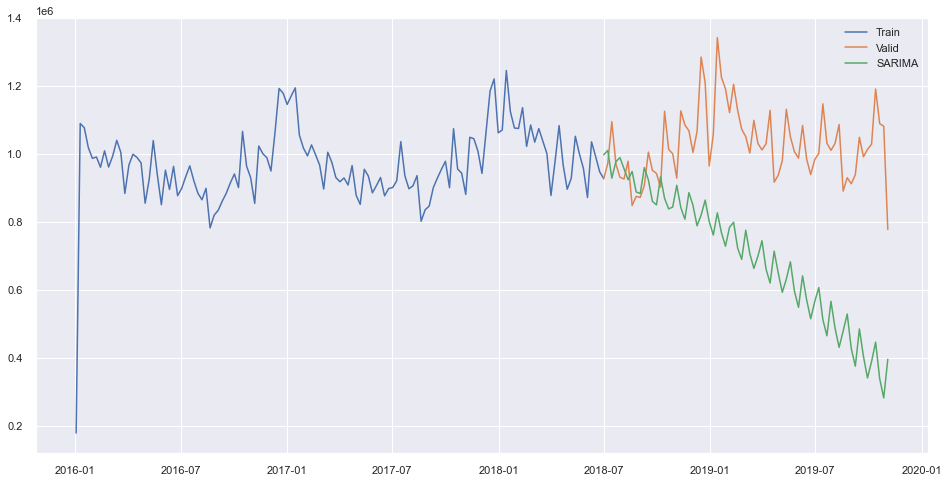

In [94]:
fit2 = SARIMAX(train['Units'], order=(0,1,0),seasonal_order=(2,2,2,7),enforce_stationarity=False,enforce_invertibility=False).fit()
model['SARIMA_Gridsearch'] = fit2.predict(start="01-Jul-2018", end="03-Nov-2019", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Units'], label='Train')
plt.plot(valid['Units'], label='Valid')
plt.plot(model['SARIMA_Gridsearch'], label='SARIMA',color="g")
plt.legend(loc='best')
plt.show()

In [95]:
rmse = sqrt(mean_squared_error(valid['Units'], model.SARIMA_Gridsearch))
mae=mean_absolute_error(valid['Units'], model.SARIMA_Gridsearch)
mape=mean_absolute_percentage_error(y_true=valid['Units'],
                   y_pred=model['SARIMA_Gridsearch'])
print("MAPE_Gridsearch",mape)
print("rmse_Gridsearch:", rmse)
print("MAE_Gridsearch:", mae)

MAPE_Gridsearch 32.23765979292564
rmse_Gridsearch: 393890.6407737199
MAE_Gridsearch: 337324.32372480526


# FUNCTION

According to the evaluation metrics the parameters that we picked manually [(3,0,2),(3,2,1,7)] are the best.
The next part is to design a function where you only need to put product id and pos to get a forecast.

In [96]:
six_weeks =pd.DataFrame({'Date': ["2019-11-10","2019-11-17","2019-11-24","2019-12-01","2019-12-08","2019-12-15"]})
six_weeks["Date"]=six_weeks["Date"].astype('datetime64[ns]')
six_weeks=six_weeks.set_index("Date")

In [97]:
data_week=df.groupby(by=['Date'], as_index=False)['Units'].sum()
data_week['Date']=data_week['Date'].astype('datetime64[ns]')
data_week = data_week.resample('W', label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')
a=data_week[['Date']]

In [98]:
def forecast_product_POS(ProductName_ID,Point_of_Sale_ID):
    pr=ProductName_ID
    pos=Point_of_Sale_ID
    s=df[(df["ProductName_ID"]==pr)&(df["Point-of-Sale_ID"]==pos)]
    s=s.groupby(by=['Date'], as_index=False)['Units'].sum()
    s['Date']=s['Date'].astype('datetime64[ns]')
    if len(s)!=0:
        s = s.resample('W', label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')
        for i in list(a.Date):
            if i not in list(s.Date):
                s=s.append({'Date':i,'Units':0},ignore_index = True)
        s=s.sort_values(by=['Date'])    
        s=s.set_index("Date")
        fit1 = SARIMAX(s['Units'], order=(3,0,2),seasonal_order=(3,2,1,7),enforce_stationarity=False,enforce_invertibility=False).fit()
        six_weeks['SARIMA'] = fit1.predict(start="10-Nov-2019", end="15-Dec-2019", dynamic=True)
        re=pd.DataFrame(columns=['Date','ProductName_ID','Point_of_Sale_ID','Units'])
        re['Units']=six_weeks['SARIMA']
        re['ProductName_ID']=pr
        re['Point_of_Sale_ID']=pos
        re['Date']=six_weeks.index
        return re
    if len(s)==0:
        re=pd.DataFrame(six_weeks.index)
        for i in range(len(re)):
            re['Units']=0
            re['ProductName_ID']=pr
            re['Point_of_Sale_ID']=pos
        return re

In [99]:
def forecast_product(ProductName_ID):
    pr=ProductName_ID
    s=df[(df["ProductName_ID"]==pr)]
    s=s.groupby(by=['Date'], as_index=False)['Units'].sum()
    s['Date']=s['Date'].astype('datetime64[ns]')
    s = s.resample('W', label='right', closed = 'right', on='Date').sum().reset_index().sort_values(by='Date')
    for i in list(a.Date):
        if i not in list(s.Date):
            s=s.append({'Date':i,'Units':0},ignore_index = True)
    s=s.sort_values(by=['Date'])    
    s=s.set_index("Date")
    fit1 = SARIMAX(s['Units'], order=(3,0,2),seasonal_order=(3,2,1,7),enforce_stationarity=False,enforce_invertibility=False).fit()
    six_weeks['SARIMA'] = fit1.predict(start="10-Nov-2019", end="15-Dec-2019", dynamic=True)
    re=pd.DataFrame(columns=['Date','ProductName_ID','Units'])
    re['Units']=six_weeks['SARIMA']
    re['ProductName_ID']=pr
    re['Date']=six_weeks.index
    return re

In [100]:
# Example product 1014 and POS 1
forecast_product_POS(1014,1)

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Date  ProductName_ID  Point_of_Sale_ID      Units
Date                                                              
2019-11-10 2019-11-10            1014                 1   6.137934
2019-11-17 2019-11-17            1014                 1  10.206463
2019-11-24 2019-11-24            1014                 1   5.395108
2019-12-01 2019-12-01            1014                 1   5.134797
2019-12-08 2019-12-08            1014                 1   7.691930
2019-12-15 2019-12-15            1014                 1   6.167959

In [101]:
# Example product 1014
forecast_product(1014)

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency W-SUN will be used.

/Users/manuelborges/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Date  ProductName_ID        Units
Date                                              
2019-11-10 2019-11-10            1014  4119.582080
2019-11-17 2019-11-17            1014  4456.313404
2019-11-24 2019-11-24            1014  4037.994020
2019-12-01 2019-12-01            1014  4072.687529
2019-12-08 2019-12-08            1014  4129.166010
2019-12-15 2019-12-15            1014  4649.509269

## Sample Forecast of the products and POS with the most units sold 
We are going to have a sample of forecast for the dashboard. The Products and POS  are chosen according to the 
quantity of units sold.

In [102]:
#df_pos=df.groupby(by=['Point-of-Sale_ID'], as_index=False)['Units'].sum()
#df_pos=df_pos.sort_values(by='Units',ascending=False)
#df_pos=df_pos.head(20)
#best_20pos=list(df_pos['Point-of-Sale_ID'])
#best_20pos

In [103]:
#df_pro=df.groupby(by=['ProductName_ID'], as_index=False)['Units'].sum()
#df_pro=df_pro.sort_values(by='Units',ascending=False)
#df_pro=df_pro.head(20)
#best_20pro=list(df_pro['ProductName_ID'])
#best_20pro

In [104]:
#t=pd.DataFrame(columns=['Date','ProductName_ID','Point_of_Sale_ID','Units']) 
#z=list(best_20pro)
#w=list(best_20pos)
#for i in z:
#    for j in w:
#        t=t.append(forecast_product_POS(i,j),ignore_index=True)
#t

In [105]:
#t.to_excel("Sample_product_POS.xlsx")

## Sample forecast of the products

In [106]:
#df_pro=df.groupby(by=['ProductName_ID'], as_index=False)['Units'].sum()
#df_pro=df_pro.sort_values(by='Units',ascending=False)
#df_pro=df_pro.head(200)
#best_200pro=list(df_pro['ProductName_ID'])
#best_200pro

In [107]:
#v=pd.DataFrame(columns=['Date','ProductName_ID','Point_of_Sale_ID','Units']) 
#z=list(best_200pro)
#for i in z:
#    v=v.append(forecast_product(i),ignore_index=True)
#v

In [108]:
#v.to_excel("Sample_Product.xlsx")

## Total amount of forecast for the unit products by POS
In case you want to have the full amount of forecasts

In [109]:
#df_pos=df.groupby(by=['Point-of-Sale_ID'], as_index=False)['Units'].sum()
#df_pos=list(df_pos['Point-of-Sale_ID'])
#df_pro=df.groupby(by=['ProductName_ID'], as_index=False)['Units'].sum()
#df_pro=list(df_pro['ProductName_ID'])
#df_pro

In [110]:
#x=pd.DataFrame(columns=['Date','ProductName_ID','Point_of_Sale_ID','Units']) 
#z=list(df_pro)
#w=list(df_pos)
#for i in z:
#    for j in w:
#        x=x.append(forecast_product_POS(i,j),ignore_index=True)
#x

In [111]:
#x.to_excel("total_forecasts.xlsx")